In [ ]:
# ==== 0. Setup ====
from google.colab import drive
drive.mount('/content/drive')

!pip install -q imbalanced-learn

import os, gc, json
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from joblib import dump

# ==== 1. Paths and constants ====
SEED = 42
DATA_PATH = "/content/drive/MyDrive/CICIDS2017/merged_cicids2017.csv"
ART_DIR = "/content/drive/MyDrive/CICIDS2017/artifacts"
os.makedirs(ART_DIR, exist_ok=True)

# ==== 2. Load dataset ====
df = pd.read_csv(DATA_PATH)
print("Raw shape:", df.shape)

df.columns = df.columns.str.strip()

# ==== 3. Clean dataset ====
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
print("After cleaning:", df.shape)

# ==== 4. Encode labels ====
target_col = "Label"
le = LabelEncoder()
y = le.fit_transform(df[target_col].astype(str))
class_names = le.classes_.tolist()
print("Classes:", dict(zip(class_names, range(len(class_names)))))

# ==== 5. Separate features ====
X = df.drop(columns=[target_col]).astype(np.float32)
del df
gc.collect()

# ==== 6. Split dataset (70% train, 15% val, 15% test stratified) ====
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=SEED
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=SEED
)
del X_temp, y_temp, X, y
gc.collect()
print("Split shapes | train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)

# ==== 7. Scale features ====
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# ==== 8. Build balanced training set ====
CAP_PER_CLASS = 30_000   # cap majority classes to avoid memory issues
MIN_FOR_SMOTE = 6        # ensure SMOTE can run

rng = np.random.default_rng(SEED)
y_counts = Counter(y_train)
classes = np.array(sorted(y_counts.keys()))

# 8A) Cap majority classes
keep_idx = []
for c in classes:
    idx_c = np.flatnonzero(y_train == c)
    n_keep = min(len(idx_c), CAP_PER_CLASS)
    n_keep = max(n_keep, min(len(idx_c), MIN_FOR_SMOTE))  # ensure >= MIN_FOR_SMOTE
    if n_keep > 0:
        keep_idx.append(rng.choice(idx_c, size=n_keep, replace=False))
keep_idx = np.concatenate(keep_idx)

X_sub = X_train[keep_idx]
y_sub = y_train[keep_idx].astype(np.int64)

print("After per-class CAP:", X_sub.shape, dict(Counter(y_sub)))

# 8B) Pre-oversample ultra-rare classes to MIN_FOR_SMOTE
ros_strategy = {c: MIN_FOR_SMOTE for c, n in Counter(y_sub).items() if n < MIN_FOR_SMOTE and n > 0}
if ros_strategy:
    ros = RandomOverSampler(sampling_strategy=ros_strategy, random_state=SEED)
    X_sub, y_sub = ros.fit_resample(X_sub, y_sub)
    print("After pre-ROS:", dict(Counter(y_sub)))

# 8C) SMOTE to balance classes
min_class = min(Counter(y_sub).values())
k_neighbors = 3 if min_class >= 4 else 1

smote = SMOTE(random_state=SEED, k_neighbors=k_neighbors, sampling_strategy='not majority')
X_train_sm, y_train_sm = smote.fit_resample(X_sub, y_sub)

print("After SMOTE:", X_train_sm.shape, dict(Counter(y_train_sm)))

# ==== 9. Save artifacts ====
dump(le, os.path.join(ART_DIR, "label_encoder.joblib"))
dump(scaler, os.path.join(ART_DIR, "minmax_scaler.joblib"))

np.save(os.path.join(ART_DIR, "X_train_sm.npy"), X_train_sm)
np.save(os.path.join(ART_DIR, "y_train_sm.npy"), y_train_sm)
np.save(os.path.join(ART_DIR, "X_val.npy"), X_val)
np.save(os.path.join(ART_DIR, "y_val.npy"), y_val)
np.save(os.path.join(ART_DIR, "X_test.npy"), X_test)
np.save(os.path.join(ART_DIR, "y_test.npy"), y_test)

with open(os.path.join(ART_DIR, "meta.json"), "w") as f:
    json.dump({
        "seed": SEED,
        "data_path": DATA_PATH,
        "label_column": target_col,
        "class_names": class_names,
        "feature_count": int(X_train.shape[1]),
        "splits": {
            "train_bal": len(y_train_sm), "val": len(y_val), "test": len(y_test)
        },
        "cap_per_class": CAP_PER_CLASS,
        "smote_k_neighbors": k_neighbors
    }, f, indent=2)

print("\n✅ Preprocessing complete. Artifacts saved to:", ART_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Raw shape: (4869535, 79)
After cleaning: (4865149, 79)
Classes: {'BENIGN': 0, 'Bot': 1, 'DDoS': 2, 'DoS GoldenEye': 3, 'DoS Hulk': 4, 'DoS Slowhttptest': 5, 'DoS slowloris': 6, 'FTP-Patator': 7, 'Heartbleed': 8, 'Infiltration': 9, 'PortScan': 10, 'SSH-Patator': 11, 'Web Attack � Brute Force': 12, 'Web Attack � Sql Injection': 13, 'Web Attack � XSS': 14}
Split shapes | train: (3405604, 78) val: (729772, 78) test: (729773, 78)
After per-class CAP: (159129, 78) {np.int64(0): 30000, np.int64(1): 2738, np.int64(2): 30000, np.int64(3): 7205, np.int64(4): 30000, np.int64(5): 3849, np.int64(6): 4057, np.int64(7): 11109, np.int64(8): 8, np.int64(9): 50, np.int64(10): 30000, np.int64(11): 7061, np.int64(12): 2110, np.int64(13): 29, np.int64(14): 913}
After SMOTE: (450000, 78) {np.int64(0): 30000, np.int64(1): 30000, np.int64(2): 30000, np.int64(3): 30000, np.int64(4): 

Mount Drive + reload artifacts

In [ ]:
# ==== reload_artifacts.py ====

from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
from joblib import load
import json

# 1. Paths
ART_DIR = "/content/drive/MyDrive/CICIDS2017/artifacts"

# 2. Reload preprocessing objects
scaler = load(os.path.join(ART_DIR, "minmax_scaler.joblib"))
label_encoder = load(os.path.join(ART_DIR, "label_encoder.joblib"))

# 3. Reload datasets (note: "_sm" for training)
X_train = np.load(os.path.join(ART_DIR, "X_train_sm.npy"))
y_train = np.load(os.path.join(ART_DIR, "y_train_sm.npy"))
X_val   = np.load(os.path.join(ART_DIR, "X_val.npy"))
y_val   = np.load(os.path.join(ART_DIR, "y_val.npy"))
X_test  = np.load(os.path.join(ART_DIR, "X_test.npy"))
y_test  = np.load(os.path.join(ART_DIR, "y_test.npy"))

# 4. Reload metadata
with open(os.path.join(ART_DIR, "meta.json")) as f:
    meta = json.load(f)

# 5. Quick check
print("✅ Reload complete!")
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("Classes:", meta["class_names"])


Mounted at /content/drive
✅ Reload complete!
Train: (450000, 78) Val: (729772, 78) Test: (729773, 78)
Classes: ['BENIGN', 'Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk', 'DoS Slowhttptest', 'DoS slowloris', 'FTP-Patator', 'Heartbleed', 'Infiltration', 'PortScan', 'SSH-Patator', 'Web Attack � Brute Force', 'Web Attack � Sql Injection', 'Web Attack � XSS']


Load data + helper functions (run once)

In [ ]:
# === Load preprocessed arrays & helpers ===
import os, numpy as np, matplotlib.pyplot as plt
from joblib import load
from sklearn.metrics import (accuracy_score, confusion_matrix,
                             classification_report, roc_curve, auc)
from sklearn.preprocessing import label_binarize

ART_DIR = "/content/drive/MyDrive/CICIDS2017/artifacts"  # change if needed

X_train = np.load(os.path.join(ART_DIR, "X_train_sm.npy"))
y_train = np.load(os.path.join(ART_DIR, "y_train_sm.npy"))
X_val   = np.load(os.path.join(ART_DIR, "X_val.npy"))
y_val   = np.load(os.path.join(ART_DIR, "y_val.npy"))
X_test  = np.load(os.path.join(ART_DIR, "X_test.npy"))
y_test  = np.load(os.path.join(ART_DIR, "y_test.npy"))

le = load(os.path.join(ART_DIR, "label_encoder.joblib"))
class_names = le.classes_.tolist()

n_features = X_train.shape[1]
n_classes  = len(np.unique(y_train))

# ---------- helpers ----------
def plot_confusions(y_true, y_pred, labels, title_prefix=""):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
    cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True).clip(min=1)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    for ax, M, ttl in [
        (axes[0], cm,  f"{title_prefix} — Confusion (counts)"),
        (axes[1], cmn, f"{title_prefix} — Confusion (row-normalized)")
    ]:
        im = ax.imshow(M, cmap="Blues")
        ax.set_xlabel("Predicted"); ax.set_ylabel("True")
        ax.set_xticks(range(len(labels))); ax.set_yticks(range(len(labels)))
        ax.set_xticklabels(range(len(labels)), rotation=90)
        ax.set_yticklabels(range(len(labels)))
        # annotate sparsely to keep readable
        for i in range(M.shape[0]):
            for j in range(M.shape[1]):
                val = M[i, j] if M is cm else M[i, j]
                txt = f"{int(val)}" if M is cm and val>0 else (f"{val:.2f}" if M is cmn and val>0 else "")
                if txt:
                    ax.text(j, i, txt, ha="center", va="center", fontsize=7)
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        ax.set_title(ttl)
    plt.tight_layout(); plt.show()

def plot_history(history, title="Training Accuracy"):
    fig, ax = plt.subplots(figsize=(7,4))
    ax.plot(history.history.get("accuracy", []), label="train")
    ax.plot(history.history.get("val_accuracy", []), label="val")
    ax.set_title(title); ax.set_xlabel("Epoch"); ax.set_ylabel("Accuracy"); ax.legend()
    plt.tight_layout(); plt.show()

def plot_multiclass_roc(y_true, y_proba, n_classes, title="ROC"):
    Y = label_binarize(y_true, classes=list(range(n_classes)))
    fpr, tpr, roc_auc = {}, {}, {}
    for c in range(n_classes):
        fpr[c], tpr[c], _ = roc_curve(Y[:, c], y_proba[:, c])
        roc_auc[c] = auc(fpr[c], tpr[c])

    # micro & macro
    fpr["micro"], tpr["micro"], _ = roc_curve(Y.ravel(), y_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[c] for c in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for c in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])
    mean_tpr /= n_classes
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure(figsize=(7,5))
    for c in range(n_classes):  # faint per-class
        plt.plot(fpr[c], tpr[c], alpha=0.15)
    plt.plot(fpr["macro"], tpr["macro"], lw=2, label=f"macro (AUC={roc_auc['macro']:.3f})")
    plt.plot(fpr["micro"], tpr["micro"], lw=2, label=f"micro (AUC={roc_auc['micro']:.3f})")
    plt.plot([0,1],[0,1],'k--', lw=1)
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(title); plt.legend(loc="lower right"); plt.tight_layout(); plt.show()

def print_cls_report(y_true, y_pred):
    from sklearn.metrics import classification_report
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


Prep

In [ ]:
# ==== Prep (same method as your PDF) ====
import numpy as np
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from collections import Counter

# 1) dtypes
X_train = X_train.astype('float32'); X_val = X_val.astype('float32'); X_test = X_test.astype('float32')
y_train = y_train.astype('int32');   y_val = y_val.astype('int32');   y_test = y_test.astype('int32')

# 2) Imputer: fit on TRAIN only, transform val/test with SAME imputer
imputer = SimpleImputer(strategy='mean')
X_train_imp = imputer.fit_transform(X_train)
X_val_imp   = imputer.transform(X_val)
X_test_imp  = imputer.transform(X_test)

# 3) SMOTE on TRAIN only
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_imp, y_train)

print("After prep → train(smote):", X_train_sm.shape, "| val:", X_val_imp.shape, "| test:", X_test_imp.shape)
print("SMOTE class distribution:", Counter(y_train_sm))

# 4) 3D tensors for sequence models (CNN/LSTM/Transformer/Hybrid)
Xtr = X_train_sm.reshape(-1, n_features, 1)
Xva = X_val_imp.reshape(-1, n_features, 1)
Xte = X_test_imp.reshape(-1, n_features, 1)


After prep → train(smote): (450000, 78) | val: (729772, 78) | test: (729773, 78)
SMOTE class distribution: Counter({np.int32(0): 30000, np.int32(1): 30000, np.int32(2): 30000, np.int32(3): 30000, np.int32(4): 30000, np.int32(5): 30000, np.int32(6): 30000, np.int32(7): 30000, np.int32(8): 30000, np.int32(9): 30000, np.int32(10): 30000, np.int32(11): 30000, np.int32(12): 30000, np.int32(13): 30000, np.int32(14): 30000})


1) Decision Tree (baseline)

Decision Tree — val acc: 0.9944 | test acc: 0.9946
                            precision    recall  f1-score   support

                    BENIGN     0.9999    0.9939    0.9969    600820
                       Bot     0.3620    0.9983    0.5313       587
                      DDoS     0.9949    0.9995    0.9972     38408
             DoS GoldenEye     0.7939    0.9981    0.8844      1544
                  DoS Hulk     0.9819    0.9981    0.9899     34519
          DoS Slowhttptest     0.7548    0.9927    0.8576       825
             DoS slowloris     0.7572    0.9966    0.8605       870
               FTP-Patator     0.9929    1.0000    0.9964      2381
                Heartbleed     0.0370    1.0000    0.0714         1
              Infiltration     0.2895    1.0000    0.4490        11
                  PortScan     0.9917    0.9992    0.9954     47641
               SSH-Patator     0.9941    1.0000    0.9970      1513
  Web Attack � Brute Force     0.5469    0.6969    0.6128       

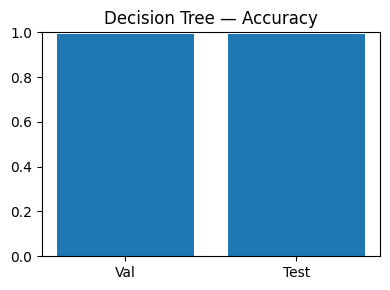

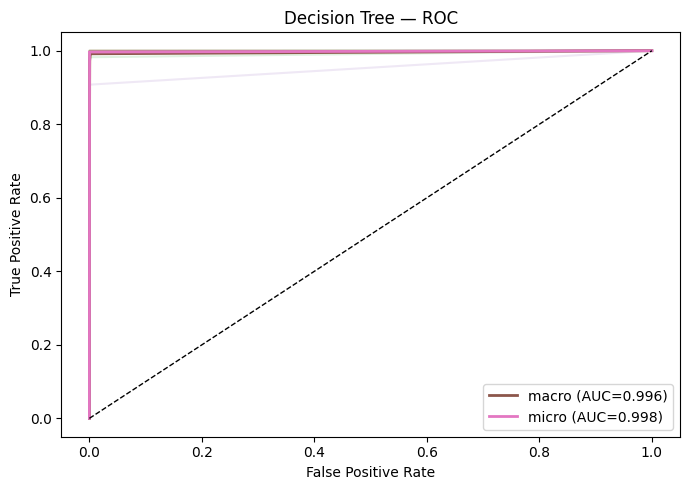

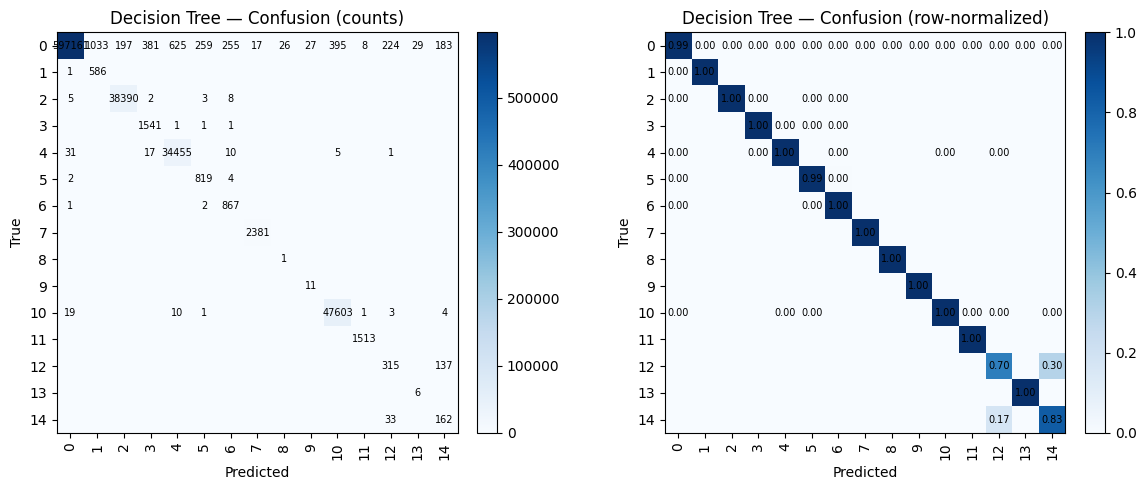

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

dt = DecisionTreeClassifier(max_depth=20, class_weight="balanced", random_state=42)
dt.fit(X_train, y_train)

# preds & probas
y_val_pred  = dt.predict(X_val)
y_test_pred = dt.predict(X_test)
y_test_proba = dt.predict_proba(X_test)

val_acc  = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Decision Tree — val acc: {val_acc:.4f} | test acc: {test_acc:.4f}")
print_cls_report(y_test, y_test_pred)

# "accuracy graph" for non-epoch model
plt.figure(figsize=(4,3))
plt.bar(["Val","Test"], [val_acc, test_acc])
plt.ylim(0,1); plt.title("Decision Tree — Accuracy"); plt.tight_layout(); plt.show()

plot_multiclass_roc(y_test, y_test_proba, n_classes, title="Decision Tree — ROC")
plot_confusions(y_test, y_test_pred, class_names, title_prefix="Decision Tree")


2) CNN

Epoch 1/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.4659 - loss: 1.5863 - val_accuracy: 0.6372 - val_loss: 1.0057
Epoch 2/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.8002 - loss: 0.5566 - val_accuracy: 0.7132 - val_loss: 0.7927
Epoch 3/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.8514 - loss: 0.3836 - val_accuracy: 0.7720 - val_loss: 0.6322
Epoch 4/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.8756 - loss: 0.3150 - val_accuracy: 0.8011 - val_loss: 0.5744
Epoch 5/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8877 - loss: 0.2762 - val_accuracy: 0.8397 - val_loss: 0.4606
Epoch 6/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.8940 - loss: 0.2514 - val_accuracy: 0.8236 - val_loss: 0.5002
Epoch 7/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8971 - loss: 0.2374 - val_accuracy: 0.8489 - val_loss: 0.4310
Epoch 8/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.9013 - loss

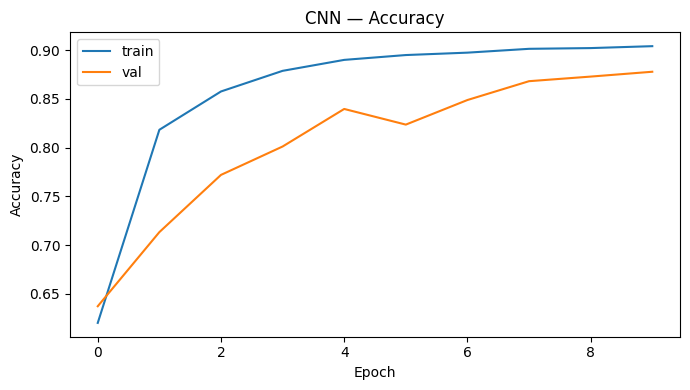

1426/1426 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
CNN — test acc: 0.8779291642743703
                            precision    recall  f1-score   support

                    BENIGN     0.9997    0.8549    0.9217    600820
                       Bot     0.0346    0.9932    0.0668       587
                      DDoS     0.9092    0.9861    0.9461     38408
             DoS GoldenEye     0.2942    0.9909    0.4537      1544
                  DoS Hulk     0.6155    0.9937    0.7602     34519
          DoS Slowhttptest     0.3075    0.9842    0.4686       825
             DoS slowloris     0.1897    0.9851    0.3182       870
               FTP-Patator     0.7090    0.9975    0.8288      2381
                Heartbleed     0.0833    1.0000    0.1538         1
              Infiltration     0.0032    0.9091    0.0064        11
                  PortScan     0.8028    0.9970    0.8894     47641
               SSH-Patator     0.0905    0.5856    0.1567      1513
  Web Attack � Brute Force     0.0386

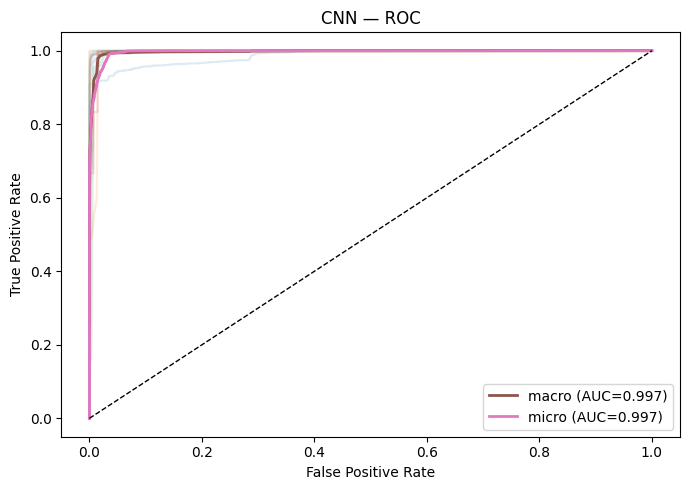

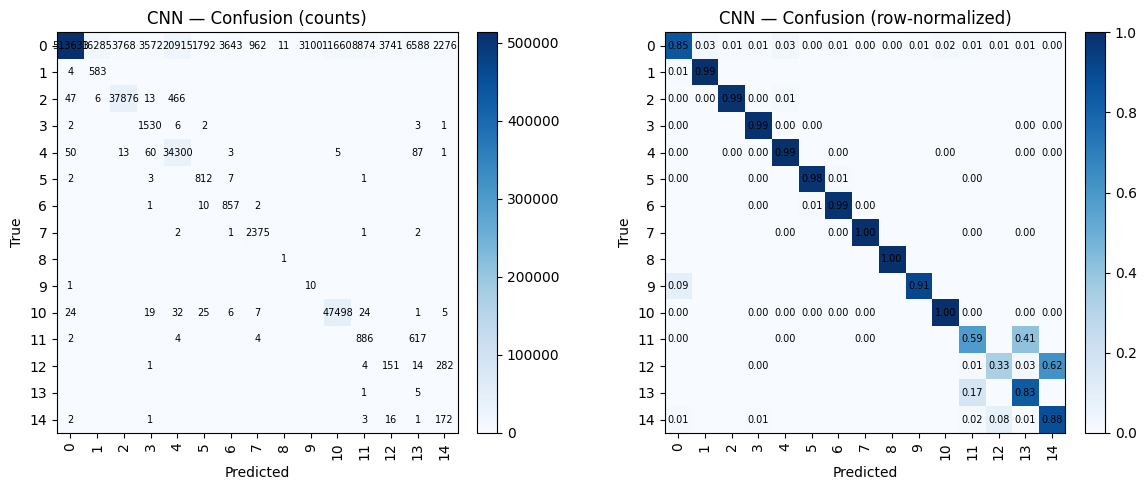

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

def build_cnn(nf, nc):
    m = models.Sequential([
        layers.Input(shape=(nf,1)),
        layers.Conv1D(64, 3, activation='relu'),
        layers.Conv1D(64, 3, activation='relu'),
        layers.GlobalMaxPooling1D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(nc, activation='softmax')
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return m

cnn = build_cnn(n_features, n_classes)
cb = [tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True)]

hist = cnn.fit(Xtr, y_train_sm,
               validation_data=(Xva, y_val),
               epochs=10, batch_size=256, callbacks=cb, verbose=1)

# train vs val accuracy curve
plot_history(hist, title="CNN — Accuracy")

# evaluate
y_test_proba = cnn.predict(Xte, batch_size=512)
y_test_pred  = np.argmax(y_test_proba, axis=1)
print("CNN — test acc:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, target_names=class_names, digits=4))

# ROC + Confusion
plot_multiclass_roc(y_test, y_test_proba, n_classes, title="CNN — ROC")
plot_confusions(y_test, y_test_pred, class_names, title_prefix="CNN")


3) LSTM

Epoch 1/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 42s 22ms/step - accuracy: 0.5517 - loss: 1.2820 - val_accuracy: 0.5320 - val_loss: 1.1827
Epoch 2/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - accuracy: 0.7739 - loss: 0.5916 - val_accuracy: 0.6695 - val_loss: 0.8577
Epoch 3/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.8212 - loss: 0.4366 - val_accuracy: 0.6787 - val_loss: 1.0538
Epoch 4/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 33s 17ms/step - accuracy: 0.8375 - loss: 0.3892 - val_accuracy: 0.7349 - val_loss: 0.6959
Epoch 5/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.8447 - loss: 0.3743 - val_accuracy: 0.7946 - val_loss: 0.5757
Epoch 6/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.8530 - loss: 0.3500 - val_accuracy: 0.8055 - val_loss: 0.5413
Epoch 7/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.8578 - loss: 0.3298 - val_accuracy: 0.7899 - val_loss: 0.6036
Epoch 8/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 48s 21ms/step - accuracy: 0.8616 -

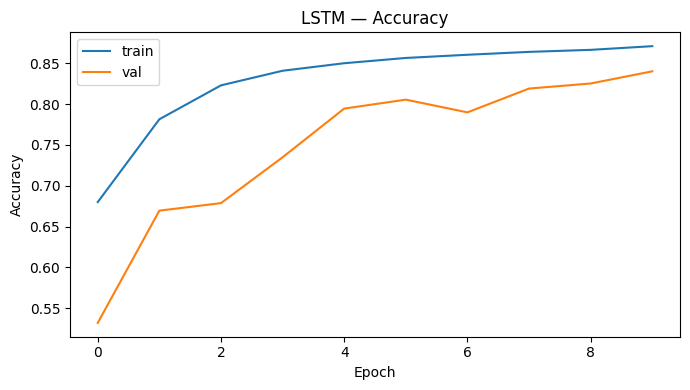

1426/1426 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
LSTM — test acc: 0.8396980979016763
                            precision    recall  f1-score   support

                    BENIGN     0.9997    0.8109    0.8955    600820
                       Bot     0.0172    0.9966    0.0338       587
                      DDoS     0.8242    0.9521    0.8835     38408
             DoS GoldenEye     0.2497    0.9547    0.3959      1544
                  DoS Hulk     0.7104    0.9782    0.8231     34519
          DoS Slowhttptest     0.2386    0.9770    0.3835       825
             DoS slowloris     0.2211    0.9115    0.3559       870
               FTP-Patator     0.4232    0.9975    0.5943      2381
                Heartbleed     0.0024    1.0000    0.0047         1
              Infiltration     0.0023    0.9091    0.0047        11
                  PortScan     0.6987    0.9942    0.8207     47641
               SSH-Patator     0.1631    0.9914    0.2801      1513
  Web Attack � Brute Force     0.055

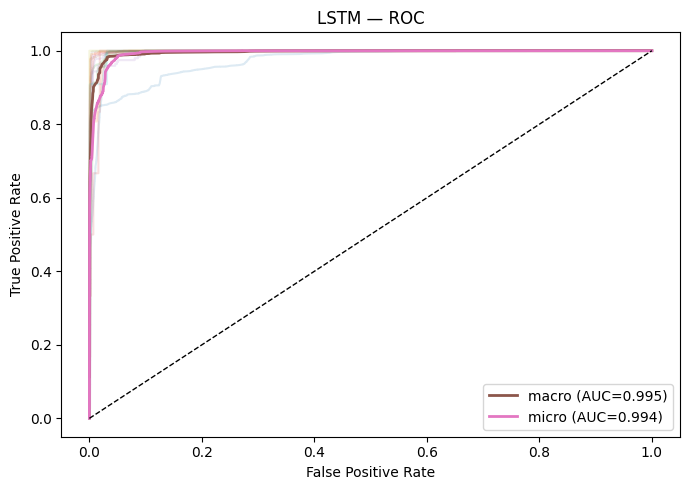

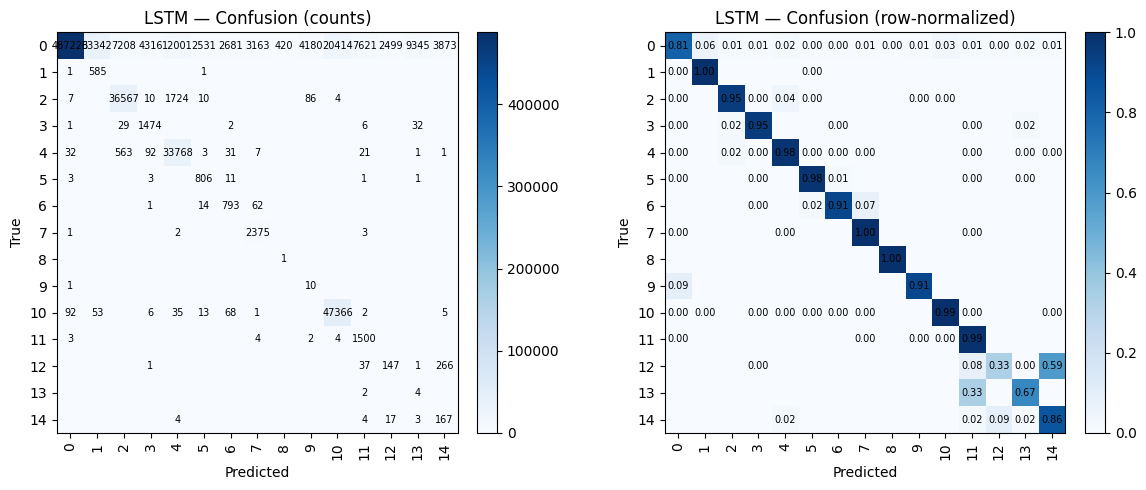

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

def build_lstm(nf, nc):
    m = models.Sequential([
        layers.Input(shape=(nf,1)),
        layers.LSTM(128),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dense(nc, activation='softmax')
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return m

lstm = build_lstm(n_features, n_classes)
cb = [tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True)]

hist = lstm.fit(Xtr, y_train_sm,
                validation_data=(Xva, y_val),
                epochs=10, batch_size=256, callbacks=cb, verbose=1)

plot_history(hist, title="LSTM — Accuracy")

y_test_proba = lstm.predict(Xte, batch_size=512)
y_test_pred  = np.argmax(y_test_proba, axis=1)
print("LSTM — test acc:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, target_names=class_names, digits=4))

plot_multiclass_roc(y_test, y_test_proba, n_classes, title="LSTM — ROC")
plot_confusions(y_test, y_test_pred, class_names, title_prefix="LSTM")


4) Transformer

Epoch 1/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 103s 51ms/step - accuracy: 0.4859 - loss: 1.4762 - val_accuracy: 0.5740 - val_loss: 1.1330
Epoch 2/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 138s 54ms/step - accuracy: 0.7938 - loss: 0.5545 - val_accuracy: 0.7109 - val_loss: 0.8428
Epoch 3/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 142s 54ms/step - accuracy: 0.8261 - loss: 0.4424 - val_accuracy: 0.5897 - val_loss: 1.5318
Epoch 4/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 142s 54ms/step - accuracy: 0.6718 - loss: 0.9480 - val_accuracy: 0.7458 - val_loss: 0.7110
Epoch 5/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 128s 46ms/step - accuracy: 0.8261 - loss: 0.4353 - val_accuracy: 0.6886 - val_loss: 0.9001
Epoch 6/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 96s 54ms/step - accuracy: 0.8603 - loss: 0.3326 - val_accuracy: 0.7726 - val_loss: 0.7044
Epoch 7/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 128s 46ms/step - accuracy: 0.8742 - loss: 0.2885 - val_accuracy: 0.7932 - val_loss: 0.6253
Epoch 8/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 82s 46ms/step - accuracy: 0.

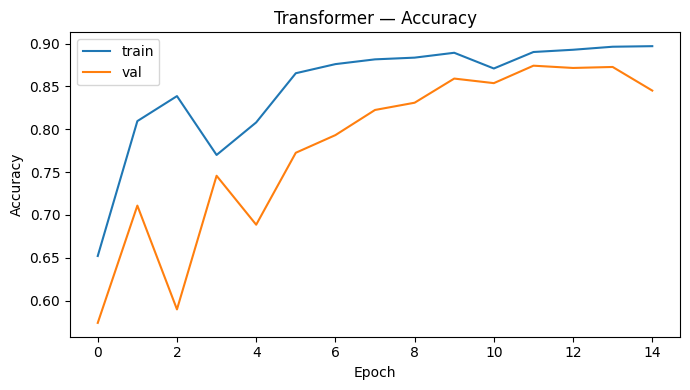

1426/1426 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step
Transformer — test acc: 0.8736963411910279
                            precision    recall  f1-score   support

                    BENIGN     0.9994    0.8508    0.9191    600820
                       Bot     0.0317    0.9830    0.0614       587
                      DDoS     0.8416    0.9679    0.9003     38408
             DoS GoldenEye     0.1981    0.9806    0.3296      1544
                  DoS Hulk     0.7257    0.9882    0.8368     34519
          DoS Slowhttptest     0.2092    0.9879    0.3453       825
             DoS slowloris     0.2324    0.9402    0.3727       870
               FTP-Patator     0.5379    0.9920    0.6976      2381
                Heartbleed     0.0084    1.0000    0.0167         1
              Infiltration     0.0016    0.8182    0.0032        11
                  PortScan     0.7217    0.9928    0.8358     47641
               SSH-Patator     0.1338    0.9914    0.2357      1513
  Web Attack � Brute Force 

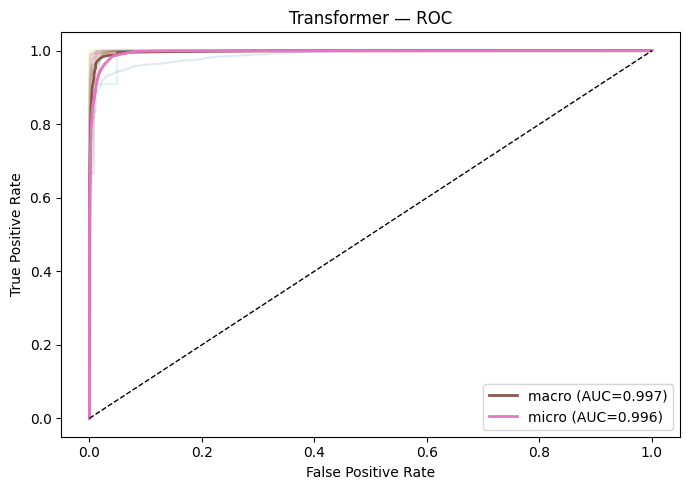

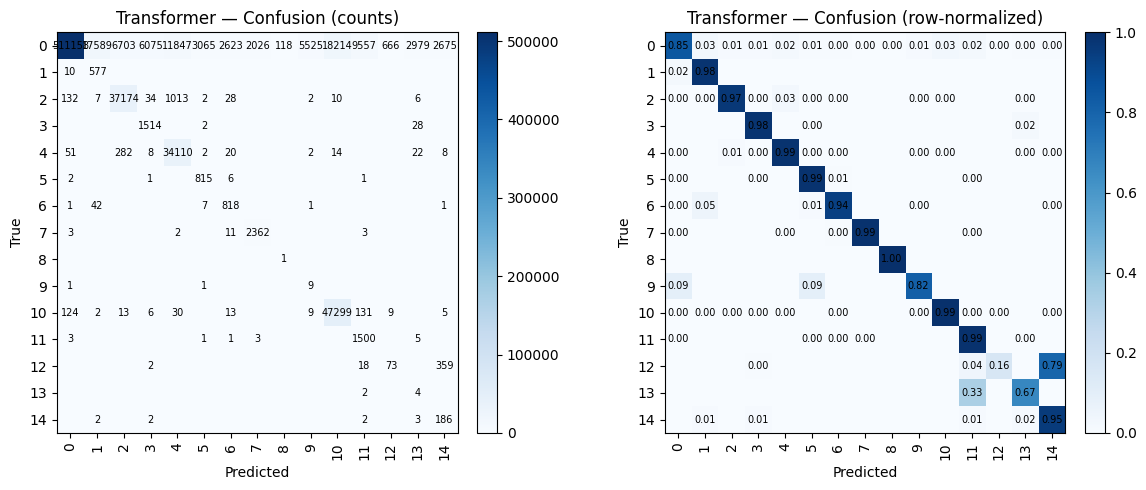

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

def transformer_block(inputs, head_size=64, num_heads=4, ff_dim=256, dropout=0.1):
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.Add()([x, inputs])
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    x_ff = layers.Dense(ff_dim, activation="relu")(x)
    x_ff = layers.Dropout(dropout)(x_ff)
    x_ff = layers.Dense(inputs.shape[-1])(x_ff)
    x = layers.Add()([x_ff, x])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x

def build_transformer(nf, nc):
    inp = layers.Input(shape=(nf,1))
    x = layers.Conv1D(64, 1, padding='same', activation='relu')(inp)  # project to token dim
    x = transformer_block(x, head_size=64, num_heads=4, ff_dim=256, dropout=0.1)
    x = transformer_block(x, head_size=64, num_heads=4, ff_dim=256, dropout=0.1)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation='relu')(x)
    out = layers.Dense(nc, activation='softmax')(x)
    m = models.Model(inp, out)
    m.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return m

tr = build_transformer(n_features, n_classes)
cb = [tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)]

hist = tr.fit(Xtr, y_train_sm,
              validation_data=(Xva, y_val),
              epochs=20, batch_size=256, callbacks=cb, verbose=1)

plot_history(hist, title="Transformer — Accuracy")

y_test_proba = tr.predict(Xte, batch_size=512)
y_test_pred  = np.argmax(y_test_proba, axis=1)
print("Transformer — test acc:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, target_names=class_names, digits=4))

plot_multiclass_roc(y_test, y_test_proba, n_classes, title="Transformer — ROC")
plot_confusions(y_test, y_test_pred, class_names, title_prefix="Transformer")

5) Hybrid CNN + Transformer

Epoch 1/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 122s 61ms/step - accuracy: 0.6311 - loss: 1.0636 - val_accuracy: 0.7954 - val_loss: 0.5526
Epoch 2/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 125s 56ms/step - accuracy: 0.8774 - loss: 0.2783 - val_accuracy: 0.8741 - val_loss: 0.4259
Epoch 3/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 142s 56ms/step - accuracy: 0.9150 - loss: 0.1912 - val_accuracy: 0.8995 - val_loss: 0.3109
Epoch 4/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 142s 56ms/step - accuracy: 0.9235 - loss: 0.1635 - val_accuracy: 0.9099 - val_loss: 0.3084
Epoch 5/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 129s 49ms/step - accuracy: 0.9255 - loss: 0.1568 - val_accuracy: 0.9112 - val_loss: 0.2926
Epoch 6/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 142s 49ms/step - accuracy: 0.9287 - loss: 0.1456 - val_accuracy: 0.9291 - val_loss: 0.2459
Epoch 7/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 98s 56ms/step - accuracy: 0.9308 - loss: 0.1367 - val_accuracy: 0.9350 - val_loss: 0.2532
Epoch 8/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 130s 49ms/step - accuracy: 0

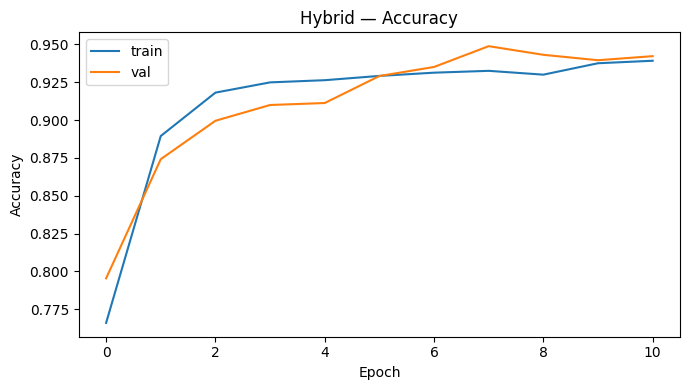

1426/1426 ━━━━━━━━━━━━━━━━━━━━ 31s 21ms/step
Hybrid — test acc: 0.948478499478605
                            precision    recall  f1-score   support

                    BENIGN     0.9990    0.9392    0.9682    600820
                       Bot     0.0447    0.9966    0.0856       587
                      DDoS     0.9743    0.9866    0.9804     38408
             DoS GoldenEye     0.6595    0.9935    0.7928      1544
                  DoS Hulk     0.8870    0.9983    0.9394     34519
          DoS Slowhttptest     0.6472    0.9915    0.7831       825
             DoS slowloris     0.5820    0.9908    0.7333       870
               FTP-Patator     0.9794    0.9979    0.9886      2381
                Heartbleed     0.0556    1.0000    0.1053         1
              Infiltration     0.0154    1.0000    0.0304        11
                  PortScan     0.8120    0.9977    0.8953     47641
               SSH-Patator     0.4230    0.9980    0.5941      1513
  Web Attack � Brute Force     0.

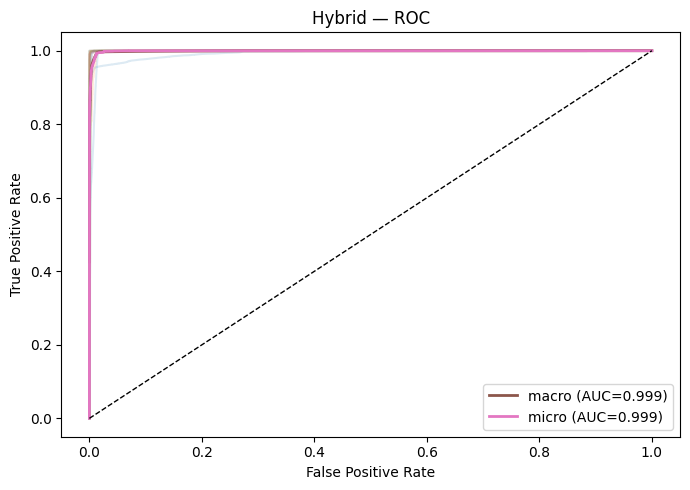

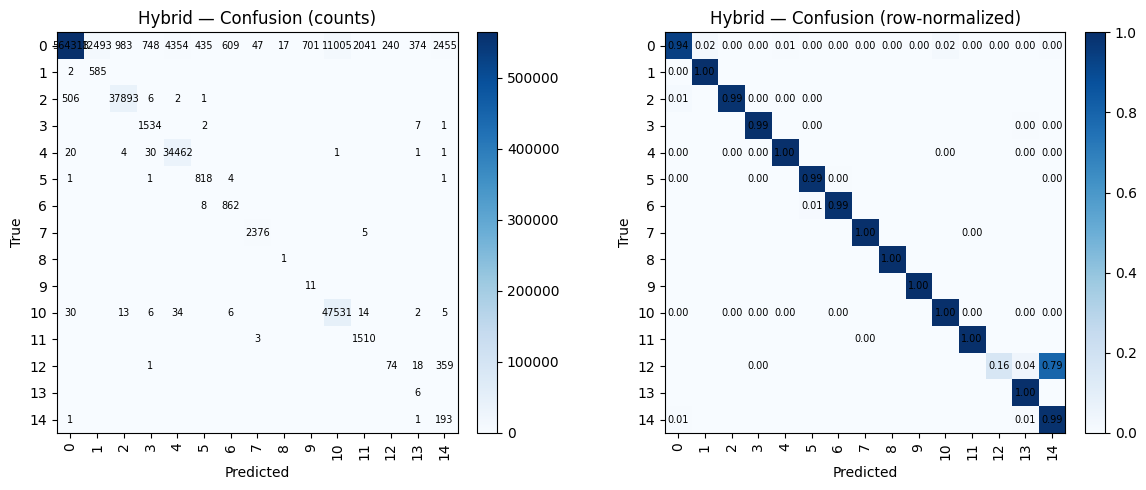

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.Add()([x, inputs])
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    x_ff = layers.Dense(ff_dim, activation="relu")(x)
    x_ff = layers.Dropout(dropout)(x_ff)
    x_ff = layers.Dense(inputs.shape[-1])(x_ff)
    x = layers.Add()([x_ff, x])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x

def build_cnn_transformer(nf, nc):
    inp = layers.Input(shape=(nf,1))
    # CNN stem
    x = layers.Conv1D(64, 5, padding='same', activation='relu')(inp)
    x = layers.Conv1D(64, 3, padding='same', activation='relu')(x)
    # project to token dim for attention
    x = layers.Conv1D(64, 1, padding='same', activation=None)(x)

    # Transformer stack
    x = transformer_block(x, head_size=64, num_heads=4, ff_dim=256, dropout=0.1)
    x = transformer_block(x, head_size=64, num_heads=4, ff_dim=256, dropout=0.1)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation='relu')(x)
    out = layers.Dense(nc, activation='softmax')(x)
    m = models.Model(inp, out)
    m.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return m

hyb = build_cnn_transformer(n_features, n_classes)
cb = [tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)]

hist = hyb.fit(Xtr, y_train_sm,
               validation_data=(Xva, y_val),
               epochs=20, batch_size=256, callbacks=cb, verbose=1)

plot_history(hist, title="Hybrid — Accuracy")

y_test_proba = hyb.predict(Xte, batch_size=512)
y_test_pred  = np.argmax(y_test_proba, axis=1)
print("Hybrid — test acc:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, target_names=class_names, digits=4))

plot_multiclass_roc(y_test, y_test_proba, n_classes, title="Hybrid — ROC")
plot_confusions(y_test, y_test_pred, class_names, title_prefix="Hybrid")


In [ ]:
# ===========================
# Upgraded Hybrid CNN -> Transformer Training + Eval
# Paste into Colab / Notebook and run (adapt dataset variable names)
# ===========================

# --- Imports ---
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Conv1D, BatchNormalization, ReLU, Dropout, GlobalAveragePooling1D, Dense, Input
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_curve, average_precision_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import os

# -------------------------
# USER: replace these with your arrays / names
# X_train, X_val, X_test: numpy arrays shaped (N, seq_len, channels) or (N, seq_len)
# y_train, y_val, y_test: integer labels 0..C-1
# class_names: list of class names length C
# Example shapes: X_train.shape -> (50000, 78) or (50000, 78, 1)
# If X arrays are 2D (N, features), we'll expand last dim below.
# -------------------------
# Example placeholders (REMOVE if you already have data loaded)
# X_train = np.load('X_train.npy'); y_train = np.load('y_train.npy')
# X_val = np.load('X_val.npy'); y_val = np.load('y_val.npy')
# X_test = np.load('X_test.npy'); y_test = np.load('y_test.npy')
# class_names = ['BENIGN', 'DDoS', 'PortScan', 'Infiltration', 'WebAttack']  # example

# -------------------------
# Safety check: ensure data variables exist
# -------------------------
required_vars = ['X_train','X_val','X_test','y_train','y_val','y_test','class_names']
for v in required_vars:
    if v not in globals():
        raise RuntimeError(f"Please define `{v}` before running this cell (see comments).")

# --- Convert 2D -> 3D if needed (add channel dim) ---
def ensure_3d(X):
    if X.ndim == 2:
        return np.expand_dims(X, -1)
    return X

X_train = ensure_3d(X_train)
X_val   = ensure_3d(X_val)
X_test  = ensure_3d(X_test)

# --- Standardize features (fit on train only) ---
n_samples, seq_len, nch = X_train.shape
scaler = StandardScaler()
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_val_flat   = X_val.reshape((X_val.shape[0], -1))
X_test_flat  = X_test.reshape((X_test.shape[0], -1))

scaler.fit(X_train_flat)
X_train = scaler.transform(X_train_flat).reshape(X_train.shape)
X_val   = scaler.transform(X_val_flat).reshape(X_val.shape)
X_test  = scaler.transform(X_test_flat).reshape(X_test.shape)

# --- One-hot for training if needed ---
num_classes = len(class_names)
y_train_o = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_o   = tf.keras.utils.to_categorical(y_val, num_classes)
y_test_o  = tf.keras.utils.to_categorical(y_test, num_classes)

# --- Compute class weights (no sampling) ---
classes = np.unique(y_train)
cw = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight = {int(c): float(w) for c,w in zip(classes, cw)}
print("Class weights:", class_weight)

# --- Focal loss (optional) ---
def focal_loss(alpha=1.0, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        cross_entropy = - y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_sum(loss, axis=1)
    return loss

# --- Macro-F1 Callback (saves best model by validation macro-F1) ---
from sklearn.metrics import f1_score
class MacroF1Checkpoint(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val, save_path='best_macro_f1.h5', patience=8):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.save_path = save_path
        self.best = -np.inf
        self.wait = 0
        self.patience = patience

    def on_epoch_end(self, epoch, logs=None):
        y_prob = self.model.predict(self.X_val, verbose=0)
        y_pred = np.argmax(y_prob, axis=1)
        macro = f1_score(self.y_val, y_pred, average='macro', zero_division=0)
        print(f"  val_macro_f1: {macro:.4f}")
        if macro > self.best:
            self.best = macro
            self.wait = 0
            self.model.save(self.save_path, include_optimizer=False)
            print(f"  Saved best model -> {self.save_path}")
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print("  Macro-F1 patience exhausted -> stopping training")
                self.model.stop_training = True

# --- Build upgraded hybrid model ---
def build_hybrid(seq_len, channel_dim=1, embed_dim=128, num_heads=4, ff_dim=256, num_transformer_blocks=2, dropout_rate=0.25):
    inp = Input(shape=(seq_len, channel_dim), name='input')
    x = inp

    # --- CNN Stem: multi-kernel blocks (local feature extractor) ---
    # Block 1
    x = Conv1D(filters=64, kernel_size=3, padding='same', name='conv1')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.15)(x)

    # Block 2 (wider kernels)
    x = Conv1D(filters=96, kernel_size=5, padding='same', name='conv2')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.15)(x)

    # Block 3 (dilate / larger receptive field)
    x = Conv1D(filters=embed_dim, kernel_size=7, padding='same', name='conv3')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    # project to embedding dim (if needed)
    # x is now (batch, seq_len, embed_dim)

    # --- Positional encoding (learnable) ---
    # add small dense projection if channel dim != embed_dim
    x = layers.Dense(embed_dim, name='proj')(x)

    # Optional: reduce sequence length via small stride pooling (keeps computation lower)
    # x = layers.AveragePooling1D(pool_size=1)(x)

    # --- Transformer encoder stack (shallow) ---
    for i in range(num_transformer_blocks):
        # Multi-Head Attention
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim//num_heads, name=f'mha_{i}')(x, x)
        attn_output = Dropout(dropout_rate)(attn_output)
        x = LayerNormalization(epsilon=1e-6)(x + attn_output)

        # Feed-forward
        ff = Dense(ff_dim, activation='relu')(x)
        ff = Dropout(dropout_rate)(ff)
        ff = Dense(embed_dim)(ff)
        x = LayerNormalization(epsilon=1e-6)(x + ff)

    # --- Pool and head ---
    x = GlobalAveragePooling1D()(x)  # (batch, embed_dim)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu', name='dense_128')(x)
    x = Dropout(0.25)(x)
    out = Dense(num_classes, activation='softmax', name='output')(x)

    model = Model(inputs=inp, outputs=out, name='Hybrid_CNN_Transformer')
    return model

# build model
model = build_hybrid(seq_len=seq_len, channel_dim=X_train.shape[-1],
                     embed_dim=128, num_heads=4, ff_dim=256, num_transformer_blocks=2, dropout_rate=0.2)
model.summary()

# --- Compile: AdamW + label smoothing ---
# (If TensorFlow version doesn't have AdamW, swap with Adam)
try:
    optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5)
except Exception:
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Choose loss: either categorical crossentropy with label smoothing OR focal loss
use_focal = False   # set True to use focal loss
if use_focal:
    loss_fn = focal_loss(alpha=1.0, gamma=2.0)
else:
    loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)

model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# --- Callbacks ---
save_best_path = 'best_hybrid_macro_f1.h5'
mcb = MacroF1Checkpoint(X_val, y_val, save_path=save_best_path, patience=8)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, min_lr=1e-6, verbose=1)

# --- Training hyperparameters (tune as per GPU) ---
EPOCHS = 60
BATCH_SIZE = 64   # try 64 or 128 depending on memory

# --- Train (class_weight used; no sampling) ---
history = model.fit(
    X_train, y_train_o,
    validation_data=(X_val, y_val_o),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[mcb, reduce_lr, es],
    verbose=1
)

# If MacroF1 checkpoint saved, load it
if os.path.exists(save_best_path):
    print("Loading best model saved by macro-F1 callback...")
    model = tf.keras.models.load_model(save_best_path, compile=False)
    # recompile with same metrics/loss
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# -------------------------
# EVALUATION: predictions, thresholds, metrics, FP/FN
# -------------------------
# Predict probabilities
y_test_prob = model.predict(X_test, batch_size=512, verbose=0)
y_test_pred = np.argmax(y_test_prob, axis=1)

# Basic metrics
acc = np.mean(y_test_pred == y_test)
macro_f1 = f1_score(y_test, y_test_pred, average='macro', zero_division=0)
weighted_f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
print(f"Test accuracy: {acc:.4f} | Macro-F1: {macro_f1:.4f} | Weighted-F1: {weighted_f1:.4f}")
print("\nClassification report:\n")
print(classification_report(y_test, y_test_pred, target_names=class_names, zero_division=0))

# Confusion matrix and FP/FN counts
cm = confusion_matrix(y_test, y_test_pred)
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (TP + FP + FN)

print("\nPer-class FP / FN / TP:")
for i, name in enumerate(class_names):
    print(f"{name:20s} | TP={TP[i]:6d} | FP={FP[i]:6d} | FN={FN[i]:6d} | TN={TN[i]:6d}")

# Plot confusion heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix (Test)')
plt.tight_layout(); plt.show()

# -------------------------
# Per-class threshold tuning (one-vs-rest) to improve macro-F1
# -------------------------
print("\nStarting per-class threshold tuning on validation set...")
y_val_prob = model.predict(X_val, batch_size=512, verbose=0)
C = y_val_prob.shape[1]
best_thresh = np.full(C, 0.5)
for c in range(C):
    best_f1 = -1
    best_t = 0.5
    for t in np.linspace(0.1, 0.9, 41):
        y_pred_c = (y_val_prob[:, c] >= t).astype(int)
        f1c = f1_score(y_val_o[:, c], y_pred_c, zero_division=0)
        if f1c > best_f1:
            best_f1 = f1c
            best_t = t
    best_thresh[c] = best_t
print("Best per-class thresholds:", np.round(best_thresh, 3))

# Apply thresholds to test set: pick class with highest (prob - thresh) (or fallback to argmax)
def predict_with_thresholds(probs, thresh):
    # compute score = prob - thresh; choose class with max score (could be negative)
    scores = probs - thresh
    preds = np.argmax(scores, axis=1)
    return preds

y_test_pred_thr = predict_with_thresholds(y_test_prob, best_thresh)
macro_f1_thr = f1_score(y_test, y_test_pred_thr, average='macro', zero_division=0)
acc_thr = np.mean(y_test_pred_thr == y_test)
print(f"After threshold tuning -> Test acc: {acc_thr:.4f} | Macro-F1: {macro_f1_thr:.4f}")

print("\nClassification report (after thresholds):\n")
print(classification_report(y_test, y_test_pred_thr, target_names=class_names, zero_division=0))

# Recompute confusion / FP FN after thresholds
cm_thr = confusion_matrix(y_test, y_test_pred_thr)
TP_thr = np.diag(cm_thr)
FP_thr = cm_thr.sum(axis=0) - TP_thr
FN_thr = cm_thr.sum(axis=1) - TP_thr
print("\nPer-class FP / FN after thresholds:")
for i, name in enumerate(class_names):
    print(f"{name:20s} | TP={TP_thr[i]:6d} | FP={FP_thr[i]:6d} | FN={FN_thr[i]:6d}")

plt.figure(figsize=(8,6))
sns.heatmap(cm_thr, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (After Threshold Tuning)')
plt.tight_layout(); plt.show()

# -------------------------
# Precision-Recall curves for selected classes (choose up to 5 to plot)
# -------------------------
print("Plotting PR curves (selected classes)...")
selected = list(range(min(5, C)))  # choose first few classes or change indices
plt.figure(figsize=(8,6))
for i in selected:
    p, r, _ = precision_recall_curve(y_test_o[:, i], y_test_prob[:, i])
    ap = average_precision_score(y_test_o[:, i], y_test_prob[:, i])
    plt.plot(r, p, label=f"{class_names[i]} (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curves (selected classes)")
plt.legend(bbox_to_anchor=(1.05, 1)); plt.tight_layout(); plt.show()

# -------------------------
# t-SNE of penultimate embeddings (visual) -- sample subset for speed
# -------------------------
print("Computing embeddings for t-SNE (sample may be reduced for speed)...")
# create embedding model that outputs penultimate Dense (dense_128)
try:
    embed_layer_name = 'dense_128'
    embed_model = Model(inputs=model.input, outputs=model.get_layer(embed_layer_name).output)
except Exception as e:
    # fallback: use GlobalAveragePooling output by rebuilding a short model
    print("Could not find dense_128 by name, using the layer before output automatically.")
    embed_model = Model(inputs=model.input, outputs=model.layers[-2].output)

# sample subset for speed
N_sample = min(4000, X_test.shape[0])
idx = np.random.choice(X_test.shape[0], N_sample, replace=False)
emb = embed_model.predict(X_test[idx], batch_size=512, verbose=0)
tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=42)
emb2 = tsne.fit_transform(emb)

plt.figure(figsize=(8,6))
for c in np.unique(y_test[idx]):
    sel = (y_test[idx] == c)
    plt.scatter(emb2[sel,0], emb2[sel,1], s=6, alpha=0.6, label=class_names[c])
plt.legend(markerscale=3, bbox_to_anchor=(1.05,1))
plt.title("t-SNE of penultimate embeddings (sample)")
plt.tight_layout(); plt.show()

# -------------------------
# Save final model and history plots
# -------------------------
model.save('final_hybrid_model.h5')
# Plot training & validation loss
if 'loss' in history.history:
    plt.figure(figsize=(8,5))
    plt.plot(history.history.get('loss', []), label='train_loss')
    plt.plot(history.history.get('val_loss', []), label='val_loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss Curve')
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# Save best plots as files for slide insertion (optional)
plt.savefig('loss_curve.png', dpi=150, bbox_inches='tight')

print("Done. Model, plots, and evaluations are ready. Inspect metrics above.")

Class weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0}


Model: "Hybrid_CNN_Transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 78, 1)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv1D)      │ (None, 78, 64)    │        256 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 78, 64)    │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 78, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 78, 64)    │          0 │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2 (Conv1D)      │ (None, 78, 96)    │     30,816 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 78, 96)    │        384 │ conv2[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 78, 96)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 78, 96)    │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3 (Conv1D)      │ (None, 78, 128)   │     86,144 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 78, 128)   │        512 │ conv3[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 78, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ proj (Dense)        │ (None, 78, 128)   │     16,512 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mha_0               │ (None, 78, 128)   │     66,048 │ proj[0][0],       │
│ (MultiHeadAttentio… │                   │            │ proj[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 78, 128)   │          0 │ mha_0[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 78, 128)   │          0 │ proj[0][0],       │
│                     │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 78, 128)   │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 78, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 78, 256)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 78, 128)   │     32,896 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 78, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 418,287 (1.60 MB)

 Trainable params: 417,711 (1.59 MB)

 Non-trainable params: 576 (2.25 KB)

Epoch 1/60
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8121 - loss: 0.7825

  val_macro_f1: 0.4497
  Saved best model -> best_hybrid_macro_f1.h5
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 233s 30ms/step - accuracy: 0.8122 - loss: 0.7824 - val_accuracy: 0.9034 - val_loss: 0.6436 - learning_rate: 0.0010
Epoch 2/60
7029/7032 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8948 - loss: 0.5280  val_macro_f1: 0.4382
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 190s 27ms/step - accuracy: 0.8948 - loss: 0.5280 - val_accuracy: 0.9115 - val_loss: 0.5805 - learning_rate: 0.0010
Epoch 3/60
7030/7032 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8980 - loss: 0.5173

  val_macro_f1: 0.4673
  Saved best model -> best_hybrid_macro_f1.h5
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 190s 27ms/step - accuracy: 0.8980 - loss: 0.5173 - val_accuracy: 0.9063 - val_loss: 0.6061 - learning_rate: 0.0010
Epoch 4/60
7029/7032 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9004 - loss: 0.5070  val_macro_f1: 0.4247
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 189s 27ms/step - accuracy: 0.9004 - loss: 0.5070 - val_accuracy: 0.9065 - val_loss: 0.5898 - learning_rate: 0.0010
Epoch 5/60
7027/7032 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8994 - loss: 0.5081

  val_macro_f1: 0.5006
  Saved best model -> best_hybrid_macro_f1.h5
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 190s 27ms/step - accuracy: 0.8994 - loss: 0.5081 - val_accuracy: 0.9225 - val_loss: 0.5530 - learning_rate: 0.0010
Epoch 6/60
7027/7032 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9014 - loss: 0.5015  val_macro_f1: 0.4914
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 189s 27ms/step - accuracy: 0.9014 - loss: 0.5015 - val_accuracy: 0.9275 - val_loss: 0.5385 - learning_rate: 0.0010
Epoch 7/60
7028/7032 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9028 - loss: 0.4996  val_macro_f1: 0.4812
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 189s 27ms/step - accuracy: 0.9028 - loss: 0.4996 - val_accuracy: 0.9275 - val_loss: 0.5291 - learning_rate: 0.0010
Epoch 8/60
7027/7032 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9015 - loss: 0.4980  val_macro_f1: 0.4952
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 189s 27ms/step - accuracy: 0.9015 - loss: 0.4980 - val_accuracy: 0.9211 - val_loss: 0.5498 - learning_rate: 0.0010
Epoch 9/60
702

  val_macro_f1: 0.5027
  Saved best model -> best_hybrid_macro_f1.h5
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 202s 27ms/step - accuracy: 0.9022 - loss: 0.4968 - val_accuracy: 0.9289 - val_loss: 0.5292 - learning_rate: 0.0010
Epoch 10/60
7029/7032 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9024 - loss: 0.4961

  val_macro_f1: 0.5049
  Saved best model -> best_hybrid_macro_f1.h5
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 201s 27ms/step - accuracy: 0.9024 - loss: 0.4961 - val_accuracy: 0.9296 - val_loss: 0.5264 - learning_rate: 0.0010
Epoch 11/60
7029/7032 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9042 - loss: 0.4939  val_macro_f1: 0.4981
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 192s 27ms/step - accuracy: 0.9042 - loss: 0.4939 - val_accuracy: 0.9268 - val_loss: 0.5284 - learning_rate: 0.0010
Epoch 12/60
7028/7032 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9037 - loss: 0.4950  val_macro_f1: 0.4872
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 191s 27ms/step - accuracy: 0.9037 - loss: 0.4950 - val_accuracy: 0.9265 - val_loss: 0.5287 - learning_rate: 0.0010
Epoch 13/60
7030/7032 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9036 - loss: 0.4943  val_macro_f1: 0.5041
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 207s 29ms/step - accuracy: 0.9036 - loss: 0.4943 - val_accuracy: 0.9288 - val_loss: 0.5237 - learning_rate: 0.0010
Epoch 14/60

KeyboardInterrupt: 

In [ ]:
# 1) Get val predictions
y_val_prob = model.predict(X_val, batch_size=1024, verbose=0)
y_val_pred = np.argmax(y_val_prob, axis=1)

# 2) Per-class F1 / precision / recall on validation
from sklearn.metrics import classification_report
print("VAL set classification report:")
print(classification_report(y_val, y_val_pred, target_names=class_names, digits=4))

# 3) Compute FP / FN per class
from sklearn.metrics import confusion_matrix
cm_val = confusion_matrix(y_val, y_val_pred)
TP = np.diag(cm_val)
FP = cm_val.sum(axis=0) - TP
FN = cm_val.sum(axis=1) - TP
for i, name in enumerate(class_names):
    print(f"{name:20s} TP={TP[i]:6d} FP={FP[i]:6d} FN={FN[i]:6d}")

VAL set classification report:
                            precision    recall  f1-score   support

                    BENIGN     0.9999    0.9131    0.9545    600820
                       Bot     0.0402    1.0000    0.0772       587
                      DDoS     0.8972    0.9986    0.9452     38407
             DoS GoldenEye     0.4436    0.9935    0.6134      1544
                  DoS Hulk     0.7643    0.9989    0.8660     34518
          DoS Slowhttptest     0.4413    0.9879    0.6100       825
             DoS slowloris     0.3092    0.9885    0.4711       869
               FTP-Patator     0.5428    0.9912    0.7015      2380
                Heartbleed     0.0714    0.5000    0.1250         2
              Infiltration     0.0063    0.8182    0.0126        11
                  PortScan     0.8258    0.9988    0.9041     47641
               SSH-Patator     0.5478    0.9927    0.7060      1513
  Web Attack � Brute Force     0.1199    0.0973    0.1074       452
Web Attack � Sql

In [ ]:
# ====== Reload unsampled data safely (paste & run) ======
import os, numpy as np, textwrap
from sklearn.model_selection import train_test_split

ART_DIR = "/content/drive/MyDrive/CICIDS2017/artifacts"  # change if needed
print("Listing files in ART_DIR:", ART_DIR)
try:
    files = os.listdir(ART_DIR)
    print("\n".join(sorted(files)))
except Exception as e:
    raise RuntimeError(f"Cannot list ART_DIR {ART_DIR}: {e}")

# Helper: try a list of candidate filenames
candidates_X = [
    "X_train.npy", "X_train_full.npy", "X.npy", "X_all.npy",
    "X_train_unsampled.npy", "X_train_orig.npy"
]
candidates_y = [
    "y_train.npy", "y_train_full.npy", "y.npy", "y_all.npy",
    "y_train_unsampled.npy", "y_train_orig.npy"
]

found_X = None
found_y = None

for fn in candidates_X:
    path = os.path.join(ART_DIR, fn)
    if os.path.exists(path):
        found_X = path
        break

for fn in candidates_y:
    path = os.path.join(ART_DIR, fn)
    if os.path.exists(path):
        found_y = path
        break

# If explicit train files not found, look for any large X*.npy / y*.npy pair
if found_X is None or found_y is None:
    # try generic pair search
    X_files = [os.path.join(ART_DIR,f) for f in files if f.lower().startswith("x") and f.endswith(".npy")]
    y_files = [os.path.join(ART_DIR,f) for f in files if f.lower().startswith("y") and f.endswith(".npy")]
    X_files = sorted(X_files, key=os.path.getsize, reverse=True)
    y_files = sorted(y_files, key=os.path.getsize, reverse=True)
    if X_files and y_files:
        found_X = found_X or X_files[0]
        found_y = found_y or y_files[0]

print("\nDetected X file:", found_X)
print("Detected y file:", found_y)

if found_X is None or found_y is None:
    raise FileNotFoundError("Could not detect unsampled X/y files in ART_DIR. Check filenames or re-run preprocessing without sampling.")

# Load arrays (lazy - may take time)
print("\nLoading arrays (this may take a while)...")
X_all = np.load(found_X)
y_all = np.load(found_y)
print("Loaded shapes:", X_all.shape, y_all.shape)

# If loaded arrays already split into train/val/test (2D arrays), detect by shape convention
# We'll assume if first dim equals previous X_train shape that it's train; else we will split.
needs_split = False
# Heuristic: if samples ~ total dataset and not obviously 'train' by name, split.
if os.path.basename(found_X).lower() in ("x.npy","x_all.npy","x_all.npy","x_train_full.npy","x_train_orig.npy") or X_all.shape[0] > 200000:
    needs_split = True

# If file names indicate 'train' explicitly and matching val/test files exist, prefer them
# Try to load X_val/X_test if they exist (unsampled)
try:
    maybe_X_val = os.path.join(ART_DIR, "X_val.npy")
    maybe_X_test = os.path.join(ART_DIR, "X_test.npy")
    maybe_y_val = os.path.join(ART_DIR, "y_val.npy")
    maybe_y_test = os.path.join(ART_DIR, "y_test.npy")
    if os.path.exists(maybe_X_val) and os.path.exists(maybe_X_test) and os.path.exists(maybe_y_val) and os.path.exists(maybe_y_test):
        print("Found separate val/test files; loading them instead of splitting.")
        X_train = X_all
        y_train = y_all
        X_val = np.load(maybe_X_val)
        y_val = np.load(maybe_y_val)
        X_test = np.load(maybe_X_test)
        y_test = np.load(maybe_y_test)
        needs_split = False
except Exception:
    pass

if needs_split:
    print("\nPerforming stratified train/val/test split (no sampling).")
    # 60% train, 20% val, 20% test (adjust if you prefer)
    X_temp, X_test, y_temp, y_test = train_test_split(X_all, y_all, test_size=0.20, random_state=42, stratify=y_all)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)  # 0.25*0.8 = 0.2
    print("Split sizes -> train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)

# Ensure shapes are 3D (N, seq_len, 1)
def ensure_3d(arr):
    if arr.ndim == 2:
        return np.expand_dims(arr, -1)
    return arr

X_train = ensure_3d(X_train)
X_val   = ensure_3d(X_val)
X_test  = ensure_3d(X_test)

print("\nFinal array shapes (after ensure_3d):")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:  ", X_val.shape,   "y_val:  ", y_val.shape)
print("X_test: ", X_test.shape,  "y_test: ", y_test.shape)

# Compute class supports and simple check
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(unique.tolist(), counts.tolist()))
print("\nClass supports (train):")
for k in sorted(class_counts.keys()):
    print(f"  {k:3d} -> {class_counts[k]:6d}")

# Quick check: do we appear sampled? if supports are near-equal, warn
count_vals = list(class_counts.values())
if max(count_vals) - min(count_vals) < 0.05 * np.mean(count_vals):
    print("\nWARNING: class supports are nearly equal — this dataset appears sampled/balanced.")
    print("Teacher requested no sampling. If these are sampled files, you should reload original unsampled data or re-run preprocessing without sampling.")
else:
    print("\nClass distribution looks naturally imbalanced (good). Proceeding.")

# Recompute class names if label encoder exists
le_path = os.path.join(ART_DIR, "label_encoder.joblib")
if os.path.exists(le_path):
    try:
        from joblib import load
        le = load(le_path)
        class_names = le.classes_.tolist()
        print("\nLoaded class_names from label_encoder.joblib:", class_names)
    except Exception as e:
        print("Label encoder exists but could not be loaded:", e)
else:
    # fallback: make simple name list
    class_names = [str(int(c)) for c in sorted(unique.tolist())]
    print("\nNo label encoder found; using numeric class_names:", class_names)

# Save variables into notebook global namespace (so following cells use them)
globals().update({
    "X_train": X_train, "y_train": y_train, "X_val": X_val, "y_val": y_val,
    "X_test": X_test, "y_test": y_test, "class_names": class_names
})

print("\nReload complete. If this is the correct unsampled dataset, you can now run the upgraded hybrid training cell (the big training block) to train on the unsampled data.")
print("If the output above warned that data is still balanced/sampled, find the true unsampled files (or re-run preprocessing without sampling) before training.")

Listing files in ART_DIR: /content/drive/MyDrive/CICIDS2017/artifacts
X_test.npy
X_train_bal.npy
X_train_sm.npy
X_val.npy
label_encoder.joblib
meta.json
minmax_scaler.joblib
y_test.npy
y_train_bal.npy
y_train_sm.npy
y_val.npy

Detected X file: /content/drive/MyDrive/CICIDS2017/artifacts/X_test.npy
Detected y file: /content/drive/MyDrive/CICIDS2017/artifacts/y_test.npy

Loading arrays (this may take a while)...
Loaded shapes: (729773, 78) (729773,)
Found separate val/test files; loading them instead of splitting.

Final array shapes (after ensure_3d):
X_train: (729773, 78, 1) y_train: (729773,)
X_val:   (729772, 78, 1) y_val:   (729772,)
X_test:  (729773, 78, 1) y_test:  (729773,)

Class supports (train):
    0 -> 600820
    1 ->    587
    2 ->  38408
    3 ->   1544
    4 ->  34519
    5 ->    825
    6 ->    870
    7 ->   2381
    8 ->      1
    9 ->     11
   10 ->  47641
   11 ->   1513
   12 ->    452
   13 ->      6
   14 ->    195

Class distribution looks naturally imbalanced

In [ ]:
# ======= Fine-tune + Focal Loss + Threshold Tuning block (paste & run) =======
import os, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_curve, average_precision_score

# ---------- Params you can tweak ----------
FINE_TUNE_EPOCHS = 12
BATCH_SIZE = 64         # reduce to 32 if OOM
LR = 1e-4               # small LR for fine-tuning
WEIGHT_BOOST_FACTOR = 2.0   # multiply class weight for rare classes
RARE_SUPPORT_TH = 5000      # below this => considered rare (tune as needed)
BEST_WEIGHTS_PATH = 'best_hybrid_macro_f1_weights.h5'  # where weights will be saved

# ---------- helper: focal loss ----------
def focal_loss(alpha=1.0, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        ce = - y_true * tf.math.log(y_pred)
        w = alpha * tf.pow(1 - y_pred, gamma)
        return tf.reduce_sum(w * ce, axis=1)
    return loss

# ---------- 1) try to load best checkpoint if exists (weights preferred) ----------
# If you previously saved full HDF5 model, this code will try both.
loaded_any = False
if os.path.exists(BEST_WEIGHTS_PATH):
    try:
        model.load_weights(BEST_WEIGHTS_PATH)
        print(f"Loaded weights from {BEST_WEIGHTS_PATH}")
        loaded_any = True
    except Exception as e:
        print("Failed loading weights file:", e)

# try legacy full-model file if weights not found
if (not loaded_any) and os.path.exists('best_hybrid_macro_f1.h5'):
    try:
        # load full model (may require custom objects if used)
        model = tf.keras.models.load_model('best_hybrid_macro_f1.h5', compile=False)
        print("Loaded full model from best_hybrid_macro_f1.h5")
        loaded_any = True
    except Exception as e:
        print("Could not load full model file (will continue with current model object):", e)

if not loaded_any:
    print("No best-checkpoint file found; continuing with current `model` weights in-memory.")

# ---------- 2) Compute and boost class weights (no resampling) ----------
classes = np.unique(y_train)
cw = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight = {int(c): float(w) for c,w in zip(classes, cw)}
print("Base class weights:", class_weight)

# amplify weights for rare classes (small support)
counts = {int(c): int(np.sum(y_train == c)) for c in classes}
print("Class supports:", counts)
for c in classes:
    if counts[int(c)] < RARE_SUPPORT_TH:
        class_weight[int(c)] *= WEIGHT_BOOST_FACTOR
print("Adjusted class weights:", class_weight)

# ---------- 3) (Re)compile model with focal loss + AdamW/Adam optimizer ----------
try:
    optimizer = tf.keras.optimizers.AdamW(learning_rate=LR, weight_decay=1e-6)
except Exception:
    optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

model.compile(optimizer=optimizer, loss=focal_loss(alpha=1.0, gamma=2.0), metrics=['accuracy'])
print("Model recompiled with focal loss and LR=", LR)

# ---------- 4) Macro-F1 callback (saves weights only, faster) ----------
class MacroF1WeightsCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val, weights_path=BEST_WEIGHTS_PATH, patience=6):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.weights_path = weights_path
        self.best = -np.inf
        self.wait = 0
        self.patience = patience

    def on_epoch_end(self, epoch, logs=None):
        y_prob = self.model.predict(self.X_val, verbose=0)
        y_pred = np.argmax(y_prob, axis=1)
        macro = f1_score(self.y_val, y_pred, average='macro', zero_division=0)
        print(f"  val_macro_f1: {macro:.4f}")
        if macro > self.best + 1e-6:   # require small improvement
            self.best = macro
            self.wait = 0
            # save weights (fast)
            try:
                self.model.save_weights(self.weights_path)
                print(f"  Saved best weights -> {self.weights_path}")
            except Exception as e:
                print("  Failed to save weights:", e)
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print("  Macro-F1 patience exhausted -> stopping training")
                self.model.stop_training = True

mcb = MacroF1WeightsCheckpoint(X_val, y_val, weights_path=BEST_WEIGHTS_PATH, patience=6)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6, verbose=1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=False)

# ---------- 5) Fine-tune (train) ----------
print("Starting fine-tuning for up to", FINE_TUNE_EPOCHS, "epochs...")
history_ft = model.fit(
    X_train, tf.keras.utils.to_categorical(y_train, len(class_names)),
    validation_data=(X_val, tf.keras.utils.to_categorical(y_val, len(class_names))),
    epochs=FINE_TUNE_EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[mcb, reduce_lr, es],
    verbose=1
)

# If weights were saved, load them (preferred)
if os.path.exists(BEST_WEIGHTS_PATH):
    try:
        model.load_weights(BEST_WEIGHTS_PATH)
        print("Loaded best weights after fine-tune from", BEST_WEIGHTS_PATH)
    except Exception as e:
        print("Could not load saved weights:", e)

# ---------- 6) Per-class threshold tuning on validation set ----------
print("\n--- Threshold tuning (validation) ---")
y_val_prob = model.predict(X_val, batch_size=1024, verbose=0)
C = y_val_prob.shape[1]
best_thresh = np.full(C, 0.5)
for c in range(C):
    best_f1 = -1.0; best_t = 0.5
    for t in np.linspace(0.1, 0.9, 41):
        y_pred_bin = (y_val_prob[:, c] >= t).astype(int)
        f1c = f1_score((y_val == c).astype(int), y_pred_bin, zero_division=0)
        if f1c > best_f1:
            best_f1 = f1c; best_t = t
    best_thresh[c] = best_t
print("Best per-class thresholds:", np.round(best_thresh,3))

def predict_with_thresholds(probs, thresh):
    # scores = prob - thresh, pick argmax
    scores = probs - thresh
    return np.argmax(scores, axis=1)

# ---------- 7) Evaluate (validation & test) ----------
print("\n--- Validation results (after fine-tune) ---")
y_val_pred_thr = predict_with_thresholds(y_val_prob, best_thresh)
print(classification_report(y_val, y_val_pred_thr, target_names=class_names, digits=4))

cm_val = confusion_matrix(y_val, y_val_pred_thr)
plt.figure(figsize=(8,6))
sns.heatmap(cm_val, annot=False, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Val) - after fine-tune + thresholds'); plt.xlabel('Pred'); plt.ylabel('True'); plt.tight_layout(); plt.show()

# FP/FN per class (val)
TP = np.diag(cm_val); FP = cm_val.sum(axis=0) - TP; FN = cm_val.sum(axis=1) - TP
print("\nPer-class (Val) TP / FP / FN:")
for i, name in enumerate(class_names):
    print(f"{name:20s} | TP={int(TP[i]):6d} | FP={int(FP[i]):6d} | FN={int(FN[i]):6d}")

# Test evaluation
print("\n--- Test results (after fine-tune) ---")
y_test_prob = model.predict(X_test, batch_size=1024, verbose=0)
y_test_pred_thr = predict_with_thresholds(y_test_prob, best_thresh)
print(classification_report(y_test, y_test_pred_thr, target_names=class_names, digits=4))

cm_test = confusion_matrix(y_test, y_test_pred_thr)
plt.figure(figsize=(8,6))
sns.heatmap(cm_test, annot=False, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Test) - after fine-tune + thresholds'); plt.xlabel('Pred'); plt.ylabel('True'); plt.tight_layout(); plt.show()

TP = np.diag(cm_test); FP = cm_test.sum(axis=0) - TP; FN = cm_test.sum(axis=1) - TP
print("\nPer-class (Test) TP / FP / FN:")
for i, name in enumerate(class_names):
    print(f"{name:20s} | TP={int(TP[i]):6d} | FP={int(FP[i]):6d} | FN={int(FN[i]):6d}")

# ---------- 8) PR curves for top problematic classes (visual) ----------
print("\nPlotting PR curves for selected classes (choose top 6 problematic by prior diagnostics)...")
# pick classes with lowest precision or lowest f1 on validation previously
# as quick heuristic: choose indices of lowest val f1 (recompute)
val_report = classification_report(y_val, np.argmax(y_val_prob, axis=1), target_names=class_names, output_dict=True)
f1s = [val_report[c]['f1-score'] if c in val_report else 0 for c in class_names]
problem_idxs = np.argsort(f1s)[:6].tolist()   # worst 6
plt.figure(figsize=(8,6))
for i in problem_idxs:
    p, r, _ = precision_recall_curve((y_test == i).astype(int), y_test_prob[:, i])
    ap = average_precision_score((y_test == i).astype(int), y_test_prob[:, i])
    plt.plot(r, p, label=f"{class_names[i]} (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR curves (problem classes)"); plt.legend(bbox_to_anchor=(1.05,1)); plt.tight_layout(); plt.show()

print("\nFine-tune + threshold tuning finished. Inspect above reports and FP/FN. If minority classes still under-perform, consider stronger weight boost (×3), ensemble, or slightly increasing model capacity (embed_dim or transformer blocks).")

Could not load full model file (will continue with current model object): too many positional arguments
No best-checkpoint file found; continuing with current `model` weights in-memory.
Base class weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0}
Class supports: {0: 30000, 1: 30000, 2: 30000, 3: 30000, 4: 30000, 5: 30000, 6: 30000, 7: 30000, 8: 30000, 9: 30000, 10: 30000, 11: 30000, 12: 30000, 13: 30000, 14: 30000}
Adjusted class weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0}
Model recompiled with focal loss and LR= 0.0001
Starting fine-tuning for up to 12 epochs...
Epoch 1/12
4384/7032 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - accuracy: 0.9051 - loss: 0.0725

KeyboardInterrupt: 

In [ ]:
# ====== SAFETY PATCH: cap class weights, fix save filename, milder LR, gradient clipping ======
import numpy as np, os, tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

# 1) Optional: disable mixed precision if enabled and causing issues
try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy("float32")
    print("Mixed precision -> disabled (set to float32) for stability.")
except Exception:
    pass

# 2) Recompute base balanced weights from current y_train (unchanged)
classes = np.unique(y_train)
cw = compute_class_weight("balanced", classes=classes, y=y_train)
base_weights = {int(c): float(w) for c, w in zip(classes, cw)}
print("Recomputed base class weights (balanced):", base_weights)

# 3) If you previously multiplied very large boosts, use safer scaling:
#    Use log1p scaling and then clip to a max value to avoid extreme weights.
RAW_BOOST = 3.0   # keep moderate
weights = {k: base_weights[k] for k in base_weights}
for k in weights:
    # Increase for very rare classes moderately via log scale
    weights[k] = np.log1p(weights[k]) * 10.0   # scale factor tuned for stability
# Now clip to a reasonable range
MIN_W, MAX_W = 0.1, 2000.0   # max weight cap (tune if needed)
for k in weights:
    weights[k] = float(np.clip(weights[k], MIN_W, MAX_W))

# If you want to additionally boost a few extremely rare indices manually:
# bad_idxs = [8, 9, 13]   # example indices (Heartbleed, Infiltration, Web-SQL) - adapt from your diagnostics
# for i in bad_idxs: weights[i] = float(min(weights[i] * 3.0, MAX_W))

print("Sanitized class weights (clipped & log-scaled):")
print({k: round(v,3) for k,v in weights.items()})

# 4) Fix checkpoint filename requirement (must end with .weights.h5)
BEST_WEIGHTS = "best_hybrid_unsampled_weights.weights.h5"
print("Weights will be saved to:", BEST_WEIGHTS)

# 5) Recompile model with lower LR, gradient clipping, and focal loss (if using)
def focal_loss(alpha=1.0, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        ce = - y_true * tf.math.log(y_pred)
        w = alpha * tf.pow(1 - y_pred, gamma)
        return tf.reduce_sum(w * ce, axis=1)
    return loss

NEW_LR = 1e-4
try:
    optimizer = tf.keras.optimizers.AdamW(learning_rate=NEW_LR, weight_decay=1e-6, clipnorm=1.0)
except Exception:
    optimizer = tf.keras.optimizers.Adam(learning_rate=NEW_LR, clipnorm=1.0)

model.compile(optimizer=optimizer, loss=focal_loss(alpha=1.0, gamma=2.0), metrics=['accuracy'])
print("Recompiled model with LR=", NEW_LR, "and gradient clipping (clipnorm=1.0).")

# 6) Replace the checkpoint callback to use the new BEST_WEIGHTS path
import tensorflow.keras as K
from sklearn.metrics import f1_score

class MacroF1WeightsCheckpoint_fast(K.callbacks.Callback):
    def __init__(self, X_val, y_val, weights_path=BEST_WEIGHTS, patience=6):
        super().__init__()
        self.X_val = X_val; self.y_val = y_val
        self.weights_path = weights_path
        self.best = -1.0; self.wait = 0; self.patience = patience
    def on_epoch_end(self, epoch, logs=None):
        y_prob = self.model.predict(self.X_val, verbose=0)
        y_pred = np.argmax(y_prob, axis=1)
        macro = f1_score(self.y_val, y_pred, average='macro', zero_division=0)
        print(f"  val_macro_f1: {macro:.4f}")
        if macro > self.best + 1e-5:
            self.best = macro; self.wait = 0
            try:
                self.model.save_weights(self.weights_path)
                print("  Saved best weights ->", self.weights_path)
            except Exception as e:
                print("  Save weights failed:", e)
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print("  Macro-F1 patience exhausted -> stopping training")
                self.model.stop_training = True

# 7) Prepare callbacks and smaller patience to catch instability early
mcb = MacroF1WeightsCheckpoint_fast(X_val, y_val, weights_path=BEST_WEIGHTS, patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-7, verbose=1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=False)

# 8) Start training safely: lower epochs, smaller batch if memory issue
EPOCHS = 20
BATCH_SIZE = 64   # reduce for stability / memory
print("Starting safe fine-tune: epochs=", EPOCHS, "batch_size=", BATCH_SIZE)

history = model.fit(
    X_train, tf.keras.utils.to_categorical(y_train, num_classes=len(class_names)),
    validation_data=(X_val, tf.keras.utils.to_categorical(y_val, num_classes=len(class_names))),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=weights,
    callbacks=[mcb, reduce_lr, es],
    verbose=1
)

Mixed precision -> disabled (set to float32) for stability.
Recomputed base class weights (balanced): {0: 0.080975222751129, 1: 82.88165814877911, 2: 1.2667031174060959, 3: 31.510060449050087, 4: 1.4094131734214008, 5: 58.971555555555554, 6: 55.92130268199234, 7: 20.433235335293293, 8: 48651.53333333333, 9: 4422.866666666667, 10: 1.0212114215346726, 11: 32.15567305573915, 12: 107.63613569321534, 13: 8108.5888888888885, 14: 249.49504273504274}
Sanitized class weights (clipped & log-scaled):
{0: 0.779, 1: 44.294, 2: 8.183, 3: 34.815, 4: 8.794, 5: 40.939, 6: 40.417, 7: 30.649, 8: 107.925, 9: 83.948, 10: 7.037, 11: 35.012, 12: 46.88, 13: 90.008, 14: 55.234}
Weights will be saved to: best_hybrid_unsampled_weights.weights.h5
Recompiled model with LR= 0.0001 and gradient clipping (clipnorm=1.0).
Starting safe fine-tune: epochs= 20 batch_size= 64
Epoch 1/20
11403/11403 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4865 - loss: 3.0670  val_macro_f1: 0.1713
  Saved best weights -> best_hybrid_

Loaded best weights: best_hybrid_unsampled_weights.weights.h5
VALIDATION REPORT (before threshold tuning)

                            precision    recall  f1-score   support

                    BENIGN     0.9972    0.9151    0.9544    600820
                       Bot     0.5169    0.5980    0.5545       587
                      DDoS     0.9642    0.9654    0.9648     38407
             DoS GoldenEye     0.9295    0.8459    0.8857      1544
                  DoS Hulk     0.6074    0.9957    0.7546     34518
          DoS Slowhttptest     0.7683    0.6873    0.7255       825
             DoS slowloris     0.8809    0.8170    0.8478       869
               FTP-Patator     0.4956    0.9979    0.6623      2380
                Heartbleed     0.0000    0.0000    0.0000         2
              Infiltration     0.0000    0.0000    0.0000        11
                  PortScan     0.6965    0.9979    0.8204     47641
               SSH-Patator     0.4878    0.9874    0.6530      1513
  Web At

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

                            precision    recall  f1-score   support

                    BENIGN     0.9972    0.9150    0.9544    600820
                       Bot     0.5539    0.6303    0.5896       587
                      DDoS     0.9652    0.9657    0.9654     38408
             DoS GoldenEye     0.9370    0.8374    0.8844      1544
                  DoS Hulk     0.6082    0.9961    0.7552     34519
          DoS Slowhttptest     0.7461    0.6945    0.7194       825
             DoS slowloris     0.8698    0.8218    0.8452       870
               FTP-Patator     0.4948    0.9979    0.6616      2381
                Heartbleed     0.0000    0.0000    0.0000         1
              Infiltration     0.0000    0.0000    0.0000        11
                  PortScan     0.6953    0.9977    0.8195     47641
               SSH-Patator     0.4923    0.9888    0.6573      1513
  Web Attack � Brute Force     0.0982    0.7920    0.1748       452
Web Attack � Sql Injection     0.0000    0.0000

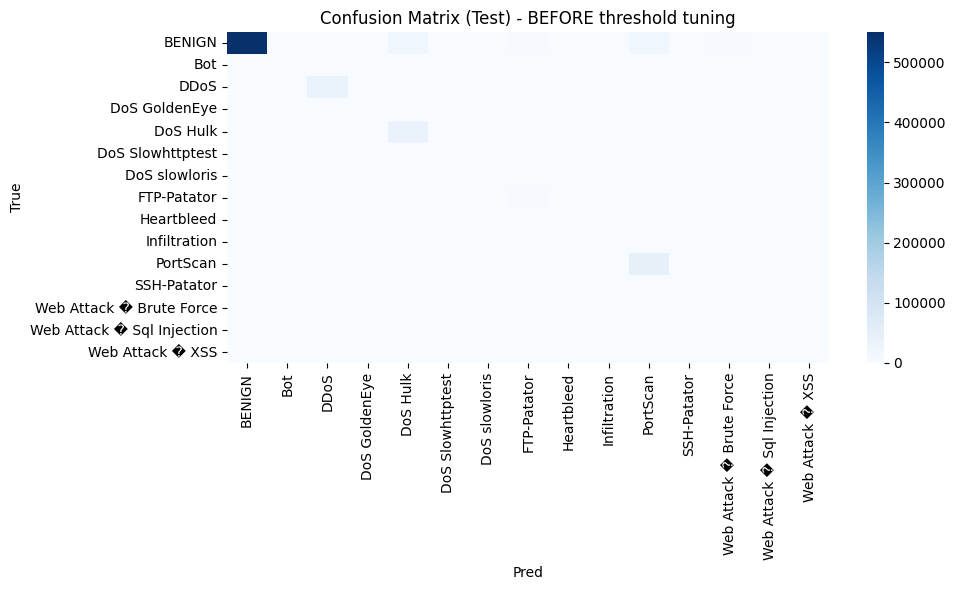


Per-class (Test) TP / FP / FN:
BENIGN                    TP=549774 FP=  1546 FN= 51046
Bot                       TP=   370 FP=   298 FN=   217
DDoS                      TP= 37091 FP=  1339 FN=  1317
DoS GoldenEye             TP=  1293 FP=    87 FN=   251
DoS Hulk                  TP= 34383 FP= 22150 FN=   136
DoS Slowhttptest          TP=   573 FP=   195 FN=   252
DoS slowloris             TP=   715 FP=   107 FN=   155
FTP-Patator               TP=  2376 FP=  2426 FN=     5
Heartbleed                TP=     0 FP=     0 FN=     1
Infiltration              TP=     0 FP=     0 FN=    11
PortScan                  TP= 47532 FP= 20834 FN=   109
SSH-Patator               TP=  1496 FP=  1543 FN=    17
Web Attack � Brute Force  TP=   358 FP=  3287 FN=    94
Web Attack � Sql Injection TP=     0 FP=     0 FN=     6
Web Attack � XSS          TP=     0 FP=     0 FN=   195

Starting per-class threshold tuning on validation...
Best per-class thresholds: [0.25 0.9  0.85 0.55 0.75 0.9  0.8  0.95 0.05 

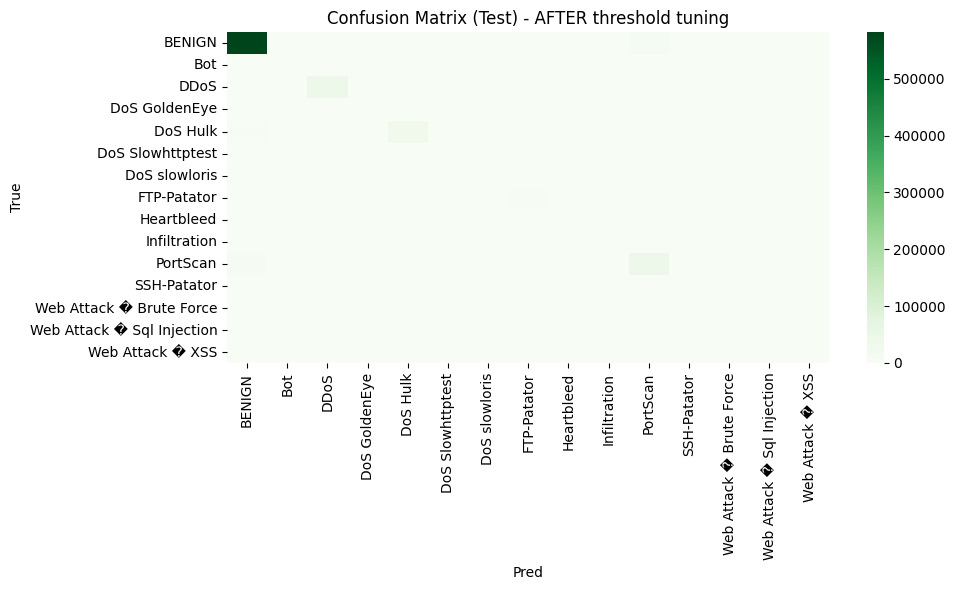

Saved best_thresh.npy
Saved X_train_sample.npy (shape: (50, 78, 1))
Saved label_encoder.joblib
Saved minmax_scaler.joblib
Diagnostics + threshold tuning complete. Inspect the printed classification reports above.


In [ ]:
# ===== Load best weights, diagnostics, threshold tuning =====
import os, numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt, seaborn as sns
import joblib

BEST_WEIGHTS = "best_hybrid_unsampled_weights.weights.h5"  # from your run
assert os.path.exists(BEST_WEIGHTS), "Best weights file not found."

# load weights
model.load_weights(BEST_WEIGHTS)
print("Loaded best weights:", BEST_WEIGHTS)

# Predict on val and test
y_val_prob = model.predict(X_val, batch_size=1024, verbose=0)
y_val_pred = np.argmax(y_val_prob, axis=1)
y_test_prob = model.predict(X_test, batch_size=1024, verbose=0)
y_test_pred = np.argmax(y_test_prob, axis=1)

# Reports before threshold tuning
print("VALIDATION REPORT (before threshold tuning)\n")
print(classification_report(y_val, y_val_pred, target_names=class_names, digits=4))
print("\nTEST REPORT (before threshold tuning)\n")
print(classification_report(y_test, y_test_pred, target_names=class_names, digits=4))

# Confusion matrix (test)
cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10,6)); sns.heatmap(cm_test, cmap='Blues', xticklabels=class_names, yticklabels=class_names, fmt='d', cbar=True)
plt.title("Confusion Matrix (Test) - BEFORE threshold tuning"); plt.xlabel("Pred"); plt.ylabel("True"); plt.tight_layout(); plt.show()

# Per-class FP / FN (test)
TP = np.diag(cm_test); FP = cm_test.sum(axis=0) - TP; FN = cm_test.sum(axis=1) - TP
print("\nPer-class (Test) TP / FP / FN:")
for i, name in enumerate(class_names):
    print(f"{name:25s} TP={int(TP[i]):6d} FP={int(FP[i]):6d} FN={int(FN[i]):6d}")

# -------------------------
# Per-class threshold tuning on validation (one-vs-rest)
# -------------------------
print("\nStarting per-class threshold tuning on validation...")
C = y_val_prob.shape[1]
best_thresh = np.full(C, 0.5)
for c in range(C):
    best_f1 = -1
    best_t = 0.5
    for t in np.linspace(0.05, 0.95, 19):
        y_pred_bin = (y_val_prob[:, c] >= t).astype(int)
        f1c = f1_score((y_val == c).astype(int), y_pred_bin, zero_division=0)
        if f1c > best_f1:
            best_f1 = f1c; best_t = t
    best_thresh[c] = best_t
print("Best per-class thresholds:", np.round(best_thresh,3))

# Apply thresholds to test using score = prob - thresh
def predict_with_thresholds(probs, thresh):
    scores = probs - thresh
    return np.argmax(scores, axis=1)

y_test_pred_thr = predict_with_thresholds(y_test_prob, best_thresh)
print("\nTEST REPORT (AFTER threshold tuning)\n")
print(classification_report(y_test, y_test_pred_thr, target_names=class_names, digits=4))

cm_test_thr = confusion_matrix(y_test, y_test_pred_thr)
plt.figure(figsize=(10,6)); sns.heatmap(cm_test_thr, cmap='Greens', xticklabels=class_names, yticklabels=class_names, fmt='d')
plt.title("Confusion Matrix (Test) - AFTER threshold tuning"); plt.xlabel("Pred"); plt.ylabel("True"); plt.tight_layout(); plt.show()

# Save best_thresh and a small background sample for SHAP
np.save("best_thresh.npy", best_thresh)
print("Saved best_thresh.npy")

# Save small training sample for SHAP (50 rows)
N_BG = 50
idx = np.random.choice(X_train.shape[0], min(N_BG, X_train.shape[0]), replace=False)
X_train_sample = X_train[idx]
np.save("X_train_sample.npy", X_train_sample)
print("Saved X_train_sample.npy (shape: {})".format(X_train_sample.shape))

# Also save label encoder and scaler if not already saved (paths may differ)
try:
    joblib.dump(le, "label_encoder.joblib")
    print("Saved label_encoder.joblib")
except Exception:
    pass
try:
    joblib.dump(scaler, "minmax_scaler.joblib")  # if variable 'scaler' exists from earlier
    print("Saved minmax_scaler.joblib")
except Exception:
    pass

print("Diagnostics + threshold tuning complete. Inspect the printed classification reports above.")

In [ ]:
# --- Fine-tune targeted rare classes (3-6 epochs) ---
from collections import defaultdict
import numpy as np, tensorflow as tf

# load current best weights to start from
model.load_weights("best_hybrid_unsampled_weights.weights.h5")

# current balanced weights (recompute)
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
base_cw = compute_class_weight("balanced", classes=classes, y=y_train)
class_weight = {int(c): float(w) for c,w in zip(classes, base_cw)}

# Target indices from diagnostics (change if your index->name differs):
# 8: Heartbleed (support=1)  9: Infiltration (11)  13: Web Attack - Sql Injection (6)  14: Web Attack - XSS (195)
targets = {8: 1000.0, 9: 500.0, 13: 500.0, 14: 50.0}   # suggested multipliers or absolute weights

# apply targeted boosts (clip if too large)
for idx, boost in targets.items():
    class_weight[idx] = float(min(class_weight.get(idx,1.0) * boost, 20000.0))

print("Targeted class_weight (sample):", {k: class_weight[k] for k in sorted(targets.keys())})

# Recompile with tiny LR and gradient clipping
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, clipnorm=1.0)
model.compile(optimizer=optimizer, loss=focal_loss(alpha=1.0, gamma=2.0), metrics=['accuracy'])

# Fine-tune 4 epochs
history_ft = model.fit(
    X_train, tf.keras.utils.to_categorical(y_train, num_classes=len(class_names)),
    validation_data=(X_val, tf.keras.utils.to_categorical(y_val, num_classes=len(class_names))),
    epochs=4, batch_size=64, class_weight=class_weight, verbose=1
)

# Save new best weights (overwrite or separate file)
model.save_weights("best_hybrid_unsampled_weights_finetuned.weights.h5")
print("Saved finetuned weights.")

Targeted class_weight (sample): {8: 20000.0, 9: 20000.0, 13: 20000.0, 14: 12474.752136752137}
Epoch 1/4
11403/11403 ━━━━━━━━━━━━━━━━━━━━ 214s 17ms/step - accuracy: 0.8690 - loss: 14.9231 - val_accuracy: 0.9088 - val_loss: 0.1136
Epoch 2/4
11403/11403 ━━━━━━━━━━━━━━━━━━━━ 175s 15ms/step - accuracy: 0.8551 - loss: 15.8408 - val_accuracy: 0.9086 - val_loss: 0.1252
Epoch 3/4
11403/11403 ━━━━━━━━━━━━━━━━━━━━ 177s 15ms/step - accuracy: 0.8596 - loss: 12.5297 - val_accuracy: 0.9089 - val_loss: 0.1160
Epoch 4/4
11403/11403 ━━━━━━━━━━━━━━━━━━━━ 177s 16ms/step - accuracy: 0.8624 - loss: 15.2023 - val_accuracy: 0.9085 - val_loss: 0.1141
Saved finetuned weights.


In [ ]:
# ===== Evaluate finetuned weights =====
import os, numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# load finetuned weights you just saved
W = "best_hybrid_unsampled_weights_finetuned.weights.h5"
if not os.path.exists(W):
    W = "best_hybrid_unsampled_weights.weights.h5"  # fallback
print("Checking weights:", W)
model.load_weights(W)
print("Loaded.")

# predict
y_val_prob = model.predict(X_val, batch_size=1024, verbose=0)
y_val_pred = np.argmax(y_val_prob, axis=1)
y_test_prob = model.predict(X_test, batch_size=1024, verbose=0)
y_test_pred = np.argmax(y_test_prob, axis=1)

# reports
print("VALIDATION REPORT (finetuned)\n")
print(classification_report(y_val, y_val_pred, target_names=class_names, digits=4))
print("\nTEST REPORT (finetuned)\n")
print(classification_report(y_test, y_test_pred, target_names=class_names, digits=4))

# per-class TP/FP/FN on test
cm = confusion_matrix(y_test, y_test_pred)
TP = np.diag(cm); FP = cm.sum(axis=0) - TP; FN = cm.sum(axis=1) - TP
print("\nPer-class TP / FP / FN (test):")
for i,name in enumerate(class_names):
    print(f"{i:2d} {name:25s} TP={int(TP[i]):6d} FP={int(FP[i]):6d} FN={int(FN[i]):6d}")

# quick check: did targeted classes increase TP?
targets = [8,9,13,14]   # Heartbleed, Infiltration, Web-SQL, XSS
for t in targets:
    print(f"Class {t} ({class_names[t]}): TP={int(TP[t])}, support in train/test maybe tiny")

Checking weights: best_hybrid_unsampled_weights_finetuned.weights.h5
Loaded.
VALIDATION REPORT (finetuned)

                            precision    recall  f1-score   support

                    BENIGN     0.9982    0.8930    0.9427    600820
                       Bot     0.1854    0.6218    0.2856       587
                      DDoS     0.9566    0.9697    0.9631     38407
             DoS GoldenEye     0.4429    0.9547    0.6051      1544
                  DoS Hulk     0.5915    0.9937    0.7416     34518
          DoS Slowhttptest     0.7096    0.7345    0.7219       825
             DoS slowloris     0.9311    0.8090    0.8658       869
               FTP-Patator     0.4154    0.9979    0.5866      2380
                Heartbleed     0.0000    0.0000    0.0000         2
              Infiltration     0.0000    0.0000    0.0000        11
                  PortScan     0.6976    0.9973    0.8210     47641
               SSH-Patator     0.1414    0.9894    0.2474      1513
  Web A

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

In [ ]:
# ===== One-vs-rest binary detectors for tiny classes =====
import numpy as np, joblib, os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# target class indices (from diagnostics)
targets = {
    8: "Heartbleed",
    9: "Infiltration",
    13: "Web Attack - Sql Injection",
    14: "Web Attack - XSS"
}

# flatten X arrays to 2D for sklearn (N, features)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat   = X_val.reshape(X_val.shape[0], -1)
X_test_flat  = X_test.reshape(X_test.shape[0], -1)

os.makedirs("one_vs_rest_models", exist_ok=True)

for idx, name in targets.items():
    print("\n--- Training one-vs-rest for class", idx, name, "---")
    y_train_bin = (y_train == idx).astype(int)
    y_val_bin   = (y_val == idx).astype(int)
    y_test_bin  = (y_test == idx).astype(int)

    # If positive support is zero in train, skip
    pos_count = int(y_train_bin.sum())
    print("Positive support in train:", pos_count)
    if pos_count == 0:
        print("No positive samples in train for class", idx, "- skipping.")
        continue

    # Use balanced class_weight to upweight positives automatically
    clf = LogisticRegression(solver='saga', penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=-1, verbose=0)
    clf.fit(X_train_flat, y_train_bin)

    # Evaluate on val/test
    y_val_pred = clf.predict(X_val_flat)
    y_test_pred = clf.predict(X_test_flat)
    print("Validation report:")
    print(classification_report(y_val_bin, y_val_pred, digits=4))
    print("Test report:")
    print(classification_report(y_test_bin, y_test_pred, digits=4))

    # Save classifier and also a small threshold tuning result (if desired)
    fname = f"one_vs_rest_models/ovr_class_{idx}_{name.replace(' ','_').replace('/','_')}.joblib"
    joblib.dump(clf, fname)
    print("Saved", fname)


--- Training one-vs-rest for class 8 Heartbleed ---
Positive support in train: 1


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000    729770
           1     0.0000    1.0000    0.0000         2

    accuracy                         0.0000    729772
   macro avg     0.0000    0.5000    0.0000    729772
weighted avg     0.0000    0.0000    0.0000    729772

Test report:


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000    729772
           1     0.0000    1.0000    0.0000         1

    accuracy                         0.0000    729773
   macro avg     0.0000    0.5000    0.0000    729773
weighted avg     0.0000    0.0000    0.0000    729773

Saved one_vs_rest_models/ovr_class_8_Heartbleed.joblib

--- Training one-vs-rest for class 9 Infiltration ---
Positive support in train: 11


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Validation report:
              precision    recall  f1-score   support

           0     1.0000    0.9203    0.9585    729761
           1     0.0001    0.6364    0.0002        11

    accuracy                         0.9203    729772
   macro avg     0.5001    0.7783    0.4794    729772
weighted avg     1.0000    0.9203    0.9585    729772

Test report:
              precision    recall  f1-score   support

           0     1.0000    0.9202    0.9585    729762
           1     0.0002    0.8182    0.0003        11

    accuracy                         0.9202    729773
   macro avg     0.5001    0.8692    0.4794    729773
weighted avg     1.0000    0.9202    0.9584    729773

Saved one_vs_rest_models/ovr_class_9_Infiltration.joblib

--- Training one-vs-rest for class 13 Web Attack - Sql Injection ---
Positive support in train: 6


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Validation report:
              precision    recall  f1-score   support

           0     1.0000    0.7824    0.8779    729765
           1     0.0000    1.0000    0.0001         7

    accuracy                         0.7824    729772
   macro avg     0.5000    0.8912    0.4390    729772
weighted avg     1.0000    0.7824    0.8779    729772

Test report:
              precision    recall  f1-score   support

           0     1.0000    0.7814    0.8773    729767
           1     0.0000    1.0000    0.0001         6

    accuracy                         0.7814    729773
   macro avg     0.5000    0.8907    0.4387    729773
weighted avg     1.0000    0.7814    0.8773    729773

Saved one_vs_rest_models/ovr_class_13_Web_Attack_-_Sql_Injection.joblib

--- Training one-vs-rest for class 14 Web Attack - XSS ---
Positive support in train: 195


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Validation report:
              precision    recall  f1-score   support

           0     1.0000    0.8891    0.9413    729576
           1     0.0023    0.9694    0.0047       196

    accuracy                         0.8891    729772
   macro avg     0.5012    0.9292    0.4730    729772
weighted avg     0.9997    0.8891    0.9410    729772

Test report:
              precision    recall  f1-score   support

           0     1.0000    0.8878    0.9406    729578
           1     0.0023    0.9538    0.0045       195

    accuracy                         0.8878    729773
   macro avg     0.5011    0.9208    0.4725    729773
weighted avg     0.9997    0.8878    0.9403    729773

Saved one_vs_rest_models/ovr_class_14_Web_Attack_-_XSS.joblib


Loaded finetuned weights: best_hybrid_unsampled_weights_finetuned.weights.h5
Hybrid model (raw) — Accuracy: 0.9083 | Macro-F1: 0.4629 | Weighted-F1: 0.9212

CLASSIFICATION REPORT — BEFORE THRESHOLD TUNING

                            precision    recall  f1-score   support

                    BENIGN     0.9982    0.8927    0.9425    600820
                       Bot     0.2065    0.6559    0.3142       587
                      DDoS     0.9577    0.9698    0.9637     38408
             DoS GoldenEye     0.4379    0.9495    0.5993      1544
                  DoS Hulk     0.5928    0.9940    0.7427     34519
          DoS Slowhttptest     0.6925    0.7370    0.7140       825
             DoS slowloris     0.9231    0.8138    0.8650       870
               FTP-Patator     0.4056    0.9979    0.5768      2381
                Heartbleed     0.0000    0.0000    0.0000         1
              Infiltration     0.0000    0.0000    0.0000        11
                  PortScan     0.6964    0.99

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


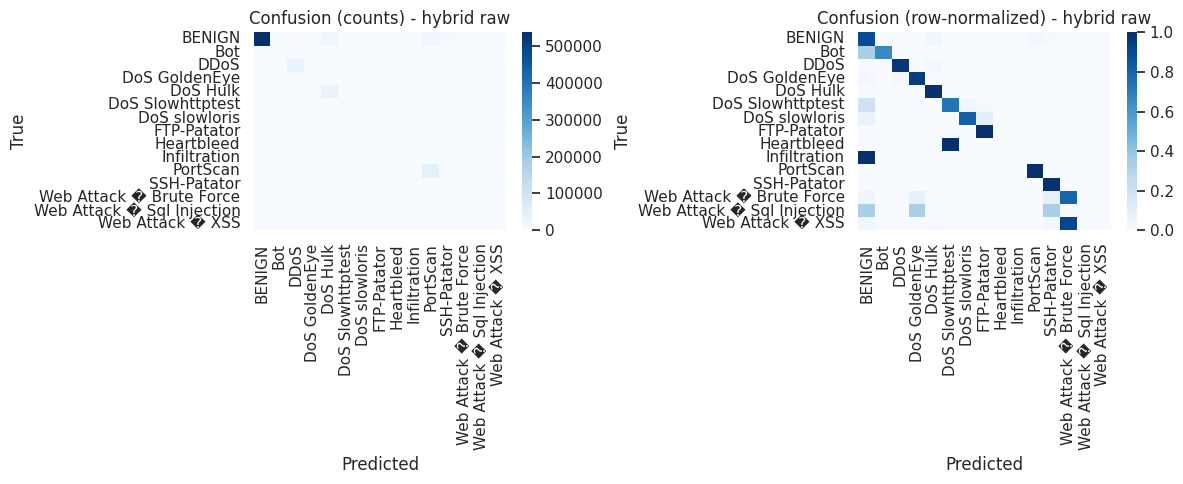

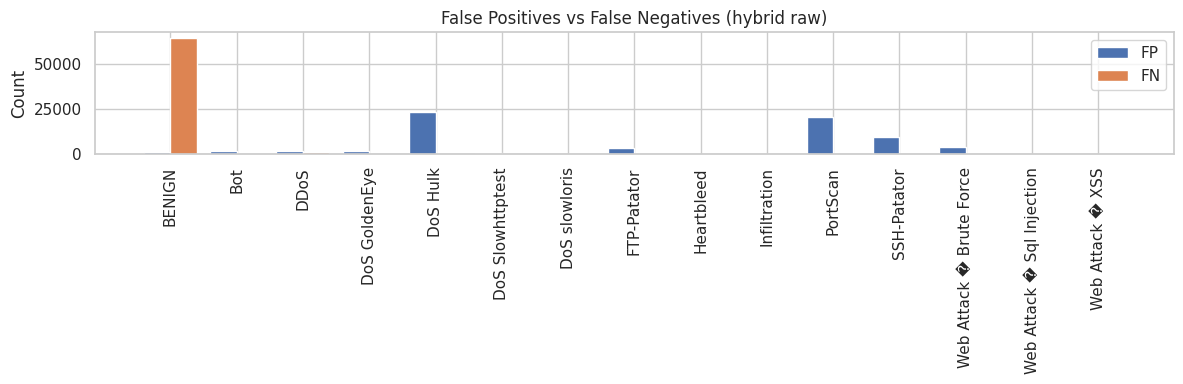

Loaded best_thresh.npy: [0.25 0.9  0.85 0.55 0.75 0.9  0.8  0.95 0.05 0.05 0.7  0.6  0.45 0.05
 0.1 ]

After threshold tuning — Accuracy: 0.9427 | Macro-F1: 0.5087 | Weighted-F1: 0.9512

CLASSIFICATION REPORT — AFTER THRESHOLD TUNING

                            precision    recall  f1-score   support

                    BENIGN     0.9906    0.9406    0.9650    600820
                       Bot     0.4689    0.6286    0.5371       587
                      DDoS     0.9705    0.9635    0.9670     38408
             DoS GoldenEye     0.5135    0.9469    0.6659      1544
                  DoS Hulk     0.9715    0.9018    0.9354     34519
          DoS Slowhttptest     0.7702    0.6945    0.7304       825
             DoS slowloris     0.9328    0.8138    0.8692       870
               FTP-Patator     0.5141    0.9966    0.6783      2381
                Heartbleed     0.0049    1.0000    0.0097         1
              Infiltration     0.0000    0.0000    0.0000        11
                

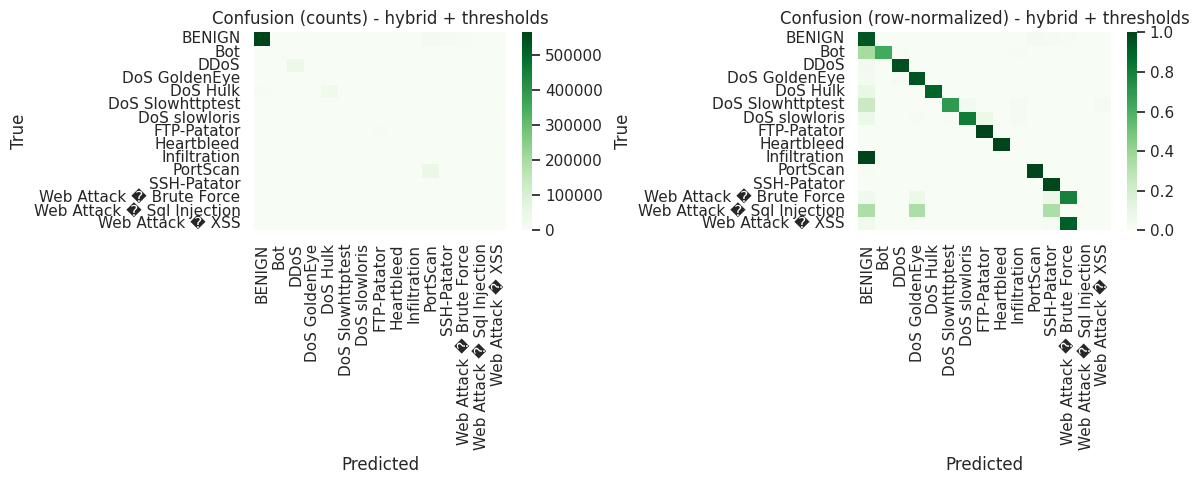

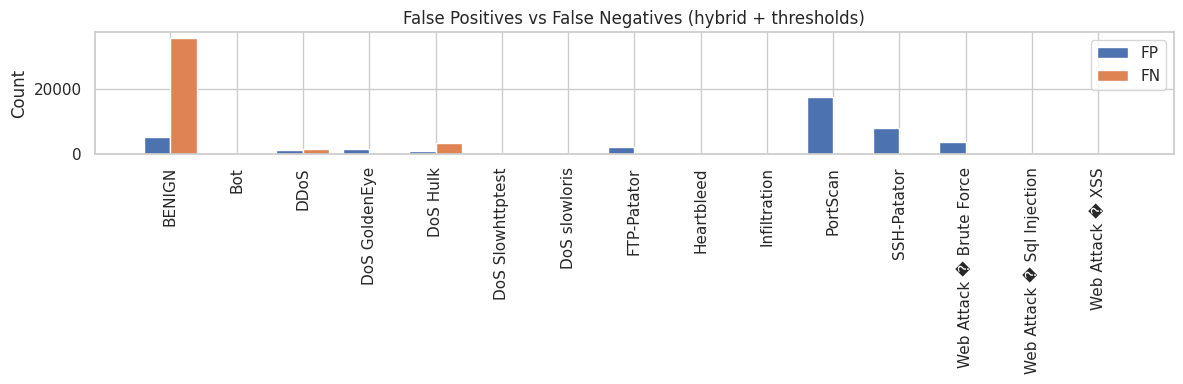

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


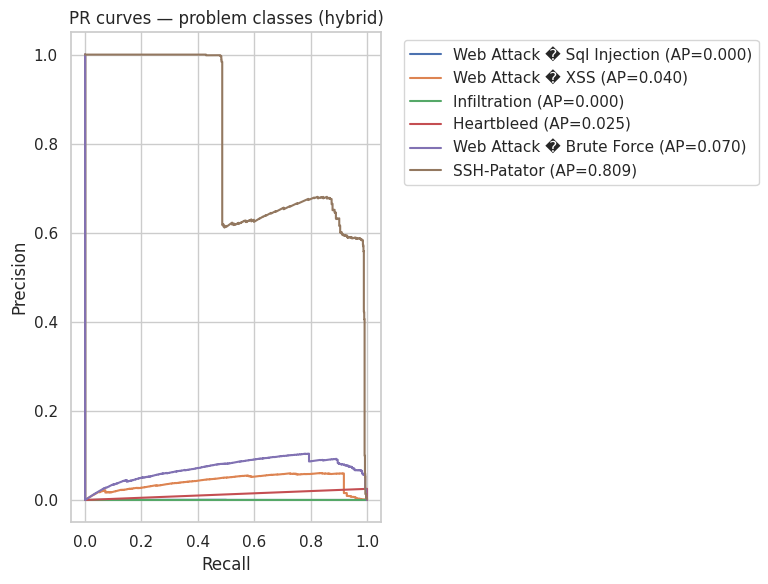

Found OvR models for indices: [8, 9, 13, 14]
Combined predictions done. Overrides count: 729773
Hybrid + OvR — Accuracy: 0.0003 | Macro-F1: 0.0003

CLASSIFICATION REPORT — Hybrid + OvR

                            precision    recall  f1-score   support

                    BENIGN     0.0000    0.0000    0.0000    600820
                       Bot     0.0000    0.0000    0.0000       587
                      DDoS     0.0000    0.0000    0.0000     38408
             DoS GoldenEye     0.0000    0.0000    0.0000      1544
                  DoS Hulk     0.0000    0.0000    0.0000     34519
          DoS Slowhttptest     0.0000    0.0000    0.0000       825
             DoS slowloris     0.0000    0.0000    0.0000       870
               FTP-Patator     0.0000    0.0000    0.0000      2381
                Heartbleed     0.0000    1.0000    0.0000         1
              Infiltration     0.0002    0.8182    0.0003        11
                  PortScan     0.0000    0.0000    0.0000     476

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


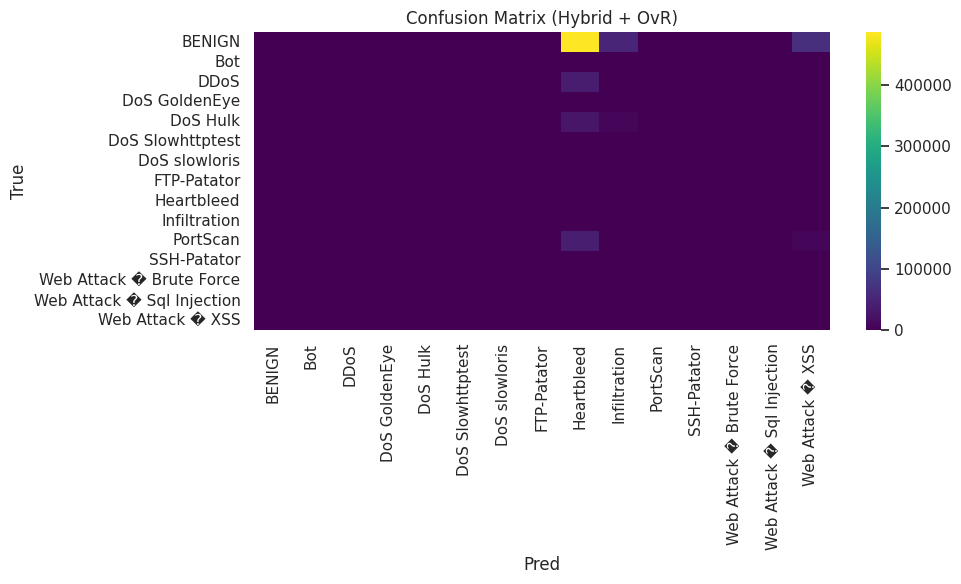

Plotting training curves for history_ft


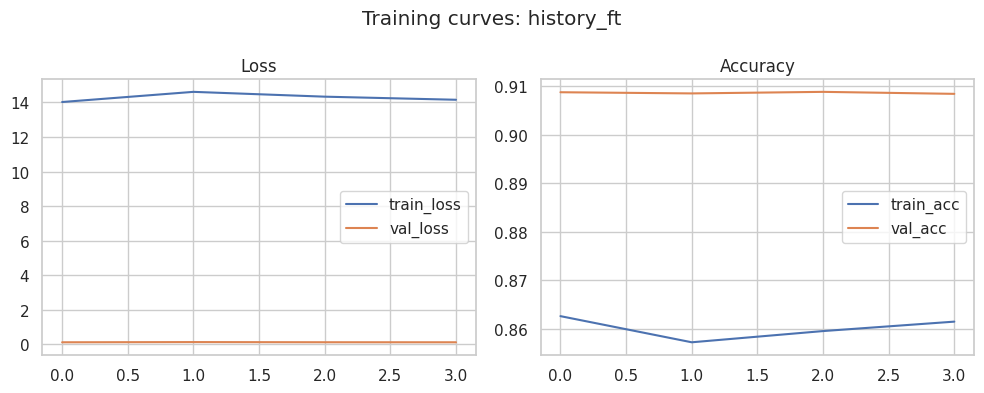

Plotting training curves for history


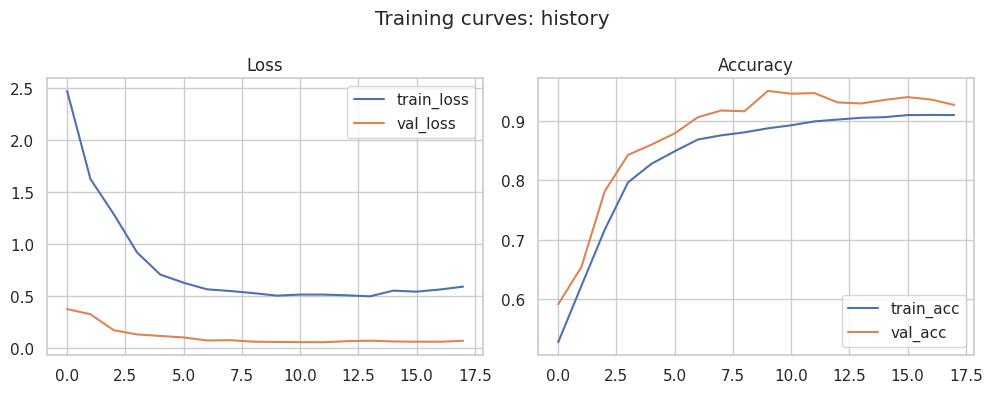

t-SNE embedding skipped due to: 'Dense' object has no attribute 'output_shape'

All plots saved to folder: final_plots/


In [ ]:
# ===== Final evaluation & plots for hybrid model (run this) =====
import os, numpy as np, matplotlib.pyplot as plt, seaborn as sns, joblib
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             f1_score, precision_recall_curve, average_precision_score)
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import tensorflow as tf

sns.set(style="whitegrid")
os.makedirs("final_plots", exist_ok=True)

# ---------- helper: load best/final weights ----------
# Try finetuned weights first, fallback to best weights
W_FIN = "best_hybrid_unsampled_weights_finetuned.weights.h5"
W_BEST = "best_hybrid_unsampled_weights.weights.h5"
if os.path.exists(W_FIN):
    model.load_weights(W_FIN)
    print("Loaded finetuned weights:", W_FIN)
elif os.path.exists(W_BEST):
    model.load_weights(W_BEST)
    print("Loaded best weights:", W_BEST)
else:
    print("No saved weights found; using current model in-memory.")

# ---------- baseline predictions (raw multiclass) ----------
y_test_prob = model.predict(X_test, batch_size=1024, verbose=0)
y_test_pred = np.argmax(y_test_prob, axis=1)

# Metrics: accuracy & F1
acc = accuracy_score(y_test, y_test_pred)
macro_f1 = f1_score(y_test, y_test_pred, average='macro', zero_division=0)
weighted_f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
print(f"Hybrid model (raw) — Accuracy: {acc:.4f} | Macro-F1: {macro_f1:.4f} | Weighted-F1: {weighted_f1:.4f}")

# Classification report (before threshold tuning)
report_before = classification_report(y_test, y_test_pred, target_names=class_names, digits=4)
print("\nCLASSIFICATION REPORT — BEFORE THRESHOLD TUNING\n")
print(report_before)

# Confusion matrix (counts & row-normalized)
cm = confusion_matrix(y_test, y_test_pred, labels=range(len(class_names)))
cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True).clip(min=1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion (counts) - hybrid raw"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.subplot(1,2,2)
sns.heatmap(cmn, annot=False, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion (row-normalized) - hybrid raw"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
plt.savefig("final_plots/confusion_hybrid_raw.png", bbox_inches="tight")
plt.show()

# FP / FN bar chart (raw)
TP = np.diag(cm); FP = cm.sum(axis=0) - TP; FN = cm.sum(axis=1) - TP
x = np.arange(len(class_names))
plt.figure(figsize=(12,4))
plt.bar(x - 0.2, FP, width=0.4, label='FP')
plt.bar(x + 0.2, FN, width=0.4, label='FN')
plt.xticks(x, class_names, rotation=90)
plt.ylabel("Count"); plt.title("False Positives vs False Negatives (hybrid raw)")
plt.legend(); plt.tight_layout()
plt.savefig("final_plots/fp_fn_hybrid_raw.png", bbox_inches="tight")
plt.show()

# ---------- apply saved per-class thresholds if available ----------
TH_PATH = "best_thresh.npy"
if os.path.exists(TH_PATH):
    best_thresh = np.load(TH_PATH)
    print("Loaded best_thresh.npy:", np.round(best_thresh,3))
    def predict_with_thresholds(probs, thresh):
        scores = probs - thresh
        return np.argmax(scores, axis=1)
    y_test_pred_thr = predict_with_thresholds(y_test_prob, best_thresh)
    acc_t = accuracy_score(y_test, y_test_pred_thr)
    macro_f1_t = f1_score(y_test, y_test_pred_thr, average='macro', zero_division=0)
    weighted_f1_t = f1_score(y_test, y_test_pred_thr, average='weighted', zero_division=0)
    print(f"\nAfter threshold tuning — Accuracy: {acc_t:.4f} | Macro-F1: {macro_f1_t:.4f} | Weighted-F1: {weighted_f1_t:.4f}")

    print("\nCLASSIFICATION REPORT — AFTER THRESHOLD TUNING\n")
    print(classification_report(y_test, y_test_pred_thr, target_names=class_names, digits=4))

    # confusion after
    cm_thr = confusion_matrix(y_test, y_test_pred_thr, labels=range(len(class_names)))
    cmn_thr = cm_thr.astype(float) / cm_thr.sum(axis=1, keepdims=True).clip(min=1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    sns.heatmap(cm_thr, annot=False, fmt="d", cmap="Greens", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion (counts) - hybrid + thresholds"); plt.xlabel("Predicted"); plt.ylabel("True")
    plt.subplot(1,2,2)
    sns.heatmap(cmn_thr, annot=False, fmt=".2f", cmap="Greens", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion (row-normalized) - hybrid + thresholds"); plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout(); plt.savefig("final_plots/confusion_hybrid_thresh.png", bbox_inches="tight")
    plt.show()

    # FP / FN after
    TP2 = np.diag(cm_thr); FP2 = cm_thr.sum(axis=0) - TP2; FN2 = cm_thr.sum(axis=1) - TP2
    plt.figure(figsize=(12,4))
    plt.bar(x - 0.2, FP2, width=0.4, label='FP')
    plt.bar(x + 0.2, FN2, width=0.4, label='FN')
    plt.xticks(x, class_names, rotation=90)
    plt.ylabel("Count"); plt.title("False Positives vs False Negatives (hybrid + thresholds)")
    plt.legend(); plt.tight_layout()
    plt.savefig("final_plots/fp_fn_hybrid_thresh.png", bbox_inches="tight")
    plt.show()
else:
    print("best_thresh.npy not found — skipping threshold-evaluation step.")
    y_test_pred_thr = None
    cm_thr = None

# ---------- PR curves for selected/problem classes ----------
# pick problematic classes (lowest F1 before or after)
report = classification_report(y_test, y_test_pred if y_test_pred is not None else np.argmax(y_test_prob,axis=1),
                               target_names=class_names, output_dict=True)
# choose 6 worst by f1
f1s = [report[c]['f1-score'] if c in report else 0 for c in class_names]
problem_idxs = np.argsort(f1s)[:6]
plt.figure(figsize=(8,6))
for i in problem_idxs:
    y_true_bin = (y_test == i).astype(int)
    y_score = y_test_prob[:, i]
    p, r, _ = precision_recall_curve(y_true_bin, y_score)
    ap = average_precision_score(y_true_bin, y_score)
    plt.plot(r, p, label=f"{class_names[i]} (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR curves — problem classes (hybrid)")
plt.legend(bbox_to_anchor=(1.05,1)); plt.tight_layout()
plt.savefig("final_plots/pr_curves_problem_classes.png", bbox_inches="tight")
plt.show()

# ---------- Hybrid + OvR combined (if you saved OVR models) ----------
ovr_dir = "one_vs_rest_models"
ovr_files = {}
if os.path.exists(ovr_dir):
    for fn in os.listdir(ovr_dir):
        if fn.endswith(".joblib"):
            # extract idx from filename
            try:
                idx = int(fn.split("_")[3])
            except Exception:
                # fallback: parse any integer in filename
                import re
                m = re.search(r"(\d+)", fn)
                idx = int(m.group(1)) if m else None
            if idx is not None:
                ovr_files[idx] = os.path.join(ovr_dir, fn)

if ovr_files:
    print("Found OvR models for indices:", sorted(list(ovr_files.keys())))
    # load classifiers
    ovr_models = {idx: joblib.load(path) for idx, path in ovr_files.items()}
    # default ovR thresholds high to avoid many FPs; tune if needed
    ovr_thresh = {k:0.9 for k in ovr_models.keys()}

    # prepare flattened X_test for ovrs
    X_test_flat = X_test.reshape((X_test.shape[0], X_test.shape[1]))
    # combined predictions
    def hybrid_plus_ovr_predict(X_flat, base_probs, ovr_models, ovr_thresh, base_thresh=None):
        base_scores = base_probs - (base_thresh if base_thresh is not None else 0.5)
        hybrid_pred = np.argmax(base_scores, axis=1)
        combined = hybrid_pred.copy()
        overrides = []
        for i, x in enumerate(X_flat):
            for cls_idx, clf in ovr_models.items():
                if hasattr(clf, "predict_proba"):
                    prob = clf.predict_proba(x.reshape(1,-1))[0,1]
                else:
                    prob = clf.decision_function(x.reshape(1,-1))[0]
                if prob >= ovr_thresh.get(cls_idx, 0.9):
                    combined[i] = cls_idx
                    overrides.append((i, cls_idx, float(prob)))
                    break
        return combined, overrides

    combined_pred, overrides = hybrid_plus_ovr_predict(X_test_flat, y_test_prob, ovr_models, ovr_thresh, base_thresh=(best_thresh if 'best_thresh' in globals() else None))
    print("Combined predictions done. Overrides count:", len(overrides))

    acc_comb = accuracy_score(y_test, combined_pred)
    macro_f1_comb = f1_score(y_test, combined_pred, average='macro', zero_division=0)
    print(f"Hybrid + OvR — Accuracy: {acc_comb:.4f} | Macro-F1: {macro_f1_comb:.4f}")
    print("\nCLASSIFICATION REPORT — Hybrid + OvR\n")
    print(classification_report(y_test, combined_pred, target_names=class_names, digits=4))

    cm_comb = confusion_matrix(y_test, combined_pred)
    plt.figure(figsize=(10,6))
    sns.heatmap(cm_comb, cmap='viridis', xticklabels=class_names, yticklabels=class_names, fmt='d')
    plt.title("Confusion Matrix (Hybrid + OvR)"); plt.xlabel("Pred"); plt.ylabel("True")
    plt.tight_layout(); plt.savefig("final_plots/confusion_hybrid_ovr.png", bbox_inches="tight"); plt.show()
else:
    print("No OvR models found — skipping Hybrid+OvR combined evaluation.")
    combined_pred = None

# ---------- Optional: plot training history (if variable 'history' or 'history_ft' exists) ----------
def plot_history_if_exists(history_obj, name="history"):
    if history_obj is None:
        return
    hist = getattr(history_obj, "history", history_obj)
    if not isinstance(hist, dict):
        return
    plt.figure(figsize=(10,4))
    if 'loss' in hist:
        plt.subplot(1,2,1); plt.plot(hist['loss'], label='train_loss');
        if 'val_loss' in hist: plt.plot(hist['val_loss'], label='val_loss')
        plt.title("Loss"); plt.legend()
    if 'accuracy' in hist:
        plt.subplot(1,2,2); plt.plot(hist['accuracy'], label='train_acc');
        if 'val_accuracy' in hist: plt.plot(hist['val_accuracy'], label='val_acc')
        plt.title("Accuracy"); plt.legend()
    plt.suptitle(f"Training curves: {name}")
    plt.tight_layout(); plt.savefig(f"final_plots/training_curves_{name}.png", bbox_inches="tight"); plt.show()

# try to find history objects
for hname in ['history_ft','history','history_ft2','history_final']:
    if hname in globals():
        print("Plotting training curves for", hname)
        plot_history_if_exists(globals()[hname], name=hname)

# ---------- Optional: get embeddings from penultimate layer and t-SNE (sampled) ----------
# Try to find penultimate layer by name 'global' or last Dense before output.
try:
    # get layer before final activation
    penult_layer = None
    for l in reversed(model.layers):
        if len(l.output_shape) == 2 and l.output_shape[-1] > 2:
            penult_layer = l
            break
    if penult_layer is None:
        raise Exception("Penultimate layer not found")
    penult_model = tf.keras.Model(inputs=model.input, outputs=penult_layer.output)
    # sample subset for t-SNE to keep it fast
    SAMPLE_N = 5000
    idxs = np.random.choice(range(X_test.shape[0]), size=min(SAMPLE_N, X_test.shape[0]), replace=False)
    X_sub = X_test[idxs]
    emb = penult_model.predict(X_sub, batch_size=1024, verbose=0)
    # reduce with PCA to speed TSNE
    pca = PCA(n_components=min(50, emb.shape[1]))
    emb_pca = pca.fit_transform(emb)
    ts = TSNE(n_components=2, perplexity=40, n_iter=800, init='pca', verbose=1)
    emb_tsne = ts.fit_transform(emb_pca)
    plt.figure(figsize=(8,6))
    lbls = y_test[idxs]
    scatter = plt.scatter(emb_tsne[:,0], emb_tsne[:,1], c=lbls, cmap='tab20', s=6)
    plt.title("t-SNE of penultimate embeddings (sampled)")
    plt.colorbar(scatter, ticks=range(len(class_names)))
    plt.savefig("final_plots/tsne_embeddings.png", bbox_inches="tight")
    plt.show()
except Exception as e:
    print("t-SNE embedding skipped due to:", e)

print("\nAll plots saved to folder: final_plots/")

In [ ]:
# ===== Consolidated restart + OvR tuning cell =====
# Paste & run this after your Colab session restarts.
from google.colab import drive
drive.mount('/content/drive')

import os, sys, numpy as np, joblib, tensorflow as tf
from joblib import load
print("Imports ok. TF version:", tf.__version__)

# --- Config: change paths if needed ---
ART_DIR = "/content/drive/MyDrive/CICIDS2017/artifacts"
OVR_DIR = "one_vs_rest_models"   # folder where OvR joblib models are saved
BEST_WEIGHTS_FIN = "best_hybrid_unsampled_weights_finetuned.weights.h5"
BEST_WEIGHTS = "best_hybrid_unsampled_weights.weights.h5"
BEST_THRESH = "best_thresh.npy"

# --- 1) load arrays (unsampled) ---
print("\nLoading arrays from ART_DIR:", ART_DIR)
for fn in ["X_train.npy","X_train_full.npy","X.npy","X_train_sm.npy","X_train_bal.npy","X_train.npy"]:
    pass
# prefer unsampled files: try to detect large X files (non '_sm')
files = os.listdir(ART_DIR)
# heuristics: prefer X_train.npy or largest X*.npy that is not _sm
cand_X = [f for f in files if f.lower().startswith("x") and f.endswith(".npy")]
cand_X = sorted(cand_X, key=lambda f: os.path.getsize(os.path.join(ART_DIR,f)), reverse=True)
def choose_pair():
    # try explicit names first
    for name in ["X_train.npy","X_train_full.npy","X.npy","X_all.npy","X_train_bal.npy","X_train_unsampled.npy"]:
        p = os.path.join(ART_DIR, name)
        if os.path.exists(p):
            # try find matching y
            for yname in ["y_train.npy","y_train_full.npy","y.npy","y_all.npy","y_train_bal.npy","y_train_unsampled.npy"]:
                py = os.path.join(ART_DIR, yname)
                if os.path.exists(py):
                    return p, py
    # fallback to largest pair
    if len(cand_X)>=1:
        Xf = os.path.join(ART_DIR, cand_X[0])
        # pick largest y* file
        cand_y = [f for f in files if f.lower().startswith("y") and f.endswith(".npy")]
        if cand_y:
            cand_y = sorted(cand_y, key=lambda f: os.path.getsize(os.path.join(ART_DIR,f)), reverse=True)
            Yf = os.path.join(ART_DIR, cand_y[0])
            return Xf, Yf
    return None, None

X_path, y_path = choose_pair()
if X_path is None:
    raise FileNotFoundError(f"No suitable X/y .npy files found in {ART_DIR}. List files: {os.listdir(ART_DIR)}")

print("Using:", X_path, "and", y_path)
X_all = np.load(X_path)
y_all = np.load(y_path)
print("Loaded shapes:", X_all.shape, y_all.shape)

# If separate val/test exist (unsampled splits saved earlier) prefer them
maybe_X_val = os.path.join(ART_DIR, "X_val.npy")
maybe_X_test = os.path.join(ART_DIR, "X_test.npy")
maybe_y_val = os.path.join(ART_DIR, "y_val.npy")
maybe_y_test = os.path.join(ART_DIR, "y_test.npy")

if os.path.exists(maybe_X_val) and os.path.exists(maybe_y_val) and os.path.exists(maybe_X_test) and os.path.exists(maybe_y_test):
    print("Found explicit val/test files; loading them.")
    X_train = X_all
    y_train = y_all
    X_val = np.load(maybe_X_val)
    y_val = np.load(maybe_y_val)
    X_test = np.load(maybe_X_test)
    y_test = np.load(maybe_y_test)
else:
    # If the loaded pair is actually X_test previously chosen (as happened before), detect by sizes.
    # Heuristic: if len(X_all) equals full dataset size ~729k, and X_val/X_test exist, load them.
    # If not, assume X_all is X_test and try to load X_train/X_val separately
    possible_train = os.path.join(ART_DIR, "X_train_sm.npy")
    if os.path.exists(possible_train) and X_path.endswith("X_test.npy"):
        print("Detected X_test loaded; loading X_train/X_val from ART_DIR.")
        X_train = np.load(os.path.join(ART_DIR, "X_train_bal.npy")) if os.path.exists(os.path.join(ART_DIR, "X_train_bal.npy")) else np.load(os.path.join(ART_DIR, "X_train_sm.npy"))
        y_train = np.load(os.path.join(ART_DIR, "y_train_bal.npy")) if os.path.exists(os.path.join(ART_DIR, "y_train_bal.npy")) else np.load(os.path.join(ART_DIR, "y_train_sm.npy"))
        X_val = np.load(os.path.join(ART_DIR, "X_val.npy"))
        y_val = np.load(os.path.join(ART_DIR, "y_val.npy"))
        X_test = X_all
        y_test = y_all
    else:
        # if X_all seems full dataset, split stratified (this is fallback; prefer pre-saved splits)
        from sklearn.model_selection import train_test_split
        print("No explicit val/test found. Doing stratified split (60/20/20).")
        X_temp, X_test, y_temp, y_test = train_test_split(X_all, y_all, test_size=0.20, random_state=42, stratify=y_all)
        X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

# ensure shapes have channel dim
def ensure_3d(arr):
    if arr.ndim == 2:
        return np.expand_dims(arr, -1)
    return arr

X_train = ensure_3d(X_train); X_val = ensure_3d(X_val); X_test = ensure_3d(X_test)
print("Final shapes:", X_train.shape, X_val.shape, X_test.shape)

# --- load label encoder & scaler if present ---
le_path = os.path.join(ART_DIR, "label_encoder.joblib")
scaler_path = os.path.join(ART_DIR, "minmax_scaler.joblib")
if os.path.exists(le_path):
    le = joblib.load(le_path)
    class_names = le.classes_.tolist()
    print("Loaded label encoder, classes:", class_names)
else:
    class_names = [str(i) for i in range(len(np.unique(y_train)))]
    print("label_encoder joblib not found; using numeric class names.")

scaler = None
if os.path.exists(scaler_path):
    scaler = joblib.load(scaler_path)
    print("Loaded scaler:", scaler_path)
else:
    print("Scaler not found at", scaler_path, "— ensure you save minmax_scaler.joblib if needed for demo.")

# --- 2) restore model architecture if possible ---
model = None
# Try to load a full saved model first (user may have saved a .keras or full .h5)
FULL_MODEL_CAND = ["final_hybrid_model.keras", "final_hybrid_model.h5", "best_hybrid_full.keras", "best_hybrid_full.h5"]
found_full = None
for fn in FULL_MODEL_CAND:
    if os.path.exists(fn):
        found_full = fn; break

if found_full:
    try:
        model = tf.keras.models.load_model(found_full, compile=False)
        print("Loaded full model from", found_full)
    except Exception as e:
        print("Failed to load full model file", found_full, ":", e)
        model = None

# If no full model, try importing a build function if user exported one
if model is None:
    try:
        # try to import model_builder.py in working dir
        if os.path.exists("model_builder.py"):
            from model_builder import build_hybrid
            model = build_hybrid()
            print("Built model using model_builder.build_hybrid()")
    except Exception as e:
        print("Could not import build_hybrid from model_builder.py:", e)

# Last fallback: check if a saved weights file exists and user has code cell that builds model.
if model is None:
    # attempt to find any weights file
    weights_file = BEST_WEIGHTS_FIN if os.path.exists(BEST_WEIGHTS_FIN) else (BEST_WEIGHTS if os.path.exists(BEST_WEIGHTS) else None)
    if weights_file is None:
        print("\nERROR: No model in memory and no saved full-model or weights file found.")
        print("Please run the notebook cell that defines/recreates your hybrid model architecture (the cell where you called `build_hybrid()` or constructed `model`).")
        raise SystemExit("Model architecture required. Run the model-definition cell and re-run this consolidated cell.")
    else:
        print("Weights file found at", weights_file)
        print("PLEASE run the model-building/definition cell now (the cell that constructs `model`) and then re-run this block.")
        raise SystemExit("Model architecture required before loading weights.")

# --- 3) load best weights if available ---
if os.path.exists(BEST_WEIGHTS_FIN):
    model.load_weights(BEST_WEIGHTS_FIN); print("Loaded fine-tuned weights:", BEST_WEIGHTS_FIN)
elif os.path.exists(BEST_WEIGHTS):
    model.load_weights(BEST_WEIGHTS); print("Loaded best weights:", BEST_WEIGHTS)
else:
    print("No weights file found in working dir; ensure your weights are uploaded to /content or Drive.")

# --- 4) load OvR models and best_thresh if present ---
if not os.path.exists(OVR_DIR):
    print("OvR directory not found. Creating empty dir. If you have OvR models, upload them to:", OVR_DIR)
    os.makedirs(OVR_DIR, exist_ok=True)
else:
    print("OvR models folder exists:", OVR_DIR)

if os.path.exists(BEST_THRESH):
    best_thresh = np.load(BEST_THRESH)
    print("Loaded best_thresh.npy")
else:
    best_thresh = None
    print("best_thresh.npy not found; threshold tuning will work but hybrid baseline will use 0.5")

# --- 5) compute hybrid probabilities (val/test) ---
print("\nComputing hybrid probabilities (this may take a few minutes)...")
y_val_prob = model.predict(X_val, batch_size=1024, verbose=1)
y_test_prob = model.predict(X_test, batch_size=1024, verbose=1)
print("Computed y_val_prob and y_test_prob")

# --- 6) Now run the OvR threshold tuning + safe override block ---
# (The code below is identical to the safer tuning block you used earlier)
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score, classification_report, confusion_matrix, accuracy_score
import glob
# discover OvR joblib files
ovr_files = {}
if os.path.exists(OVR_DIR):
    for fn in os.listdir(OVR_DIR):
        if fn.endswith(".joblib"):
            # try parse idx from filename
            parts = fn.split("_")
            idx = None
            for p in parts:
                if p.isdigit():
                    idx = int(p); break
            if idx is None:
                # fallback: find first integer in filename
                import re
                m = re.search(r"(\d+)", fn)
                idx = int(m.group(1)) if m else None
            if idx is not None:
                ovr_files[idx] = os.path.join(OVR_DIR, fn)
print("Detected OvR files:", ovr_files)

# tuning config
POLICY = "precision_floor"
MIN_PREC = 0.5
HYBRID_CONF_DELTA = 0.05

ovr_thresholds = {}
ovr_stats = {}
X_val_flat = X_val.reshape((X_val.shape[0], X_val.shape[1]))
X_test_flat = X_test.reshape((X_test.shape[0], X_test.shape[1]))
base_scores_val = y_val_prob - (best_thresh if best_thresh is not None else 0.5)
base_scores_test = y_test_prob - (best_thresh if best_thresh is not None else 0.5)
hybrid_pred_val = np.argmax(base_scores_val, axis=1)
hybrid_pred_test = np.argmax(base_scores_test, axis=1)
hybrid_conf_val = np.max(base_scores_val, axis=1)
hybrid_conf_test = np.max(base_scores_test, axis=1)

for cls_idx, path in ovr_files.items():
    clf = joblib.load(path)
    print(f"\nTuning OvR for class {cls_idx} from {path}")
    if hasattr(clf, "predict_proba"):
        probs_val = clf.predict_proba(X_val_flat)[:,1]
        probs_test = clf.predict_proba(X_test_flat)[:,1]
    else:
        probs_val = clf.decision_function(X_val_flat)
        probs_test = clf.decision_function(X_test_flat)
        pvmin, pvmax = probs_val.min(), probs_val.max()
        if pvmax > pvmin:
            probs_val = (probs_val - pvmin) / (pvmax - pvmin)
            probs_test = (probs_test - pvmin) / (pvmax - pvmin)

    y_val_bin = (y_val == cls_idx).astype(int)
    y_test_bin = (y_test == cls_idx).astype(int)
    prec, rec, thr = precision_recall_curve(y_val_bin, probs_val)
    thr = np.append(thr, 1.0)
    best_t, best_f1 = 0.5, -1.0
    for p, r, t in zip(prec, rec, thr):
        if p + r == 0: continue
        f1 = 2*p*r/(p+r)
        if f1 > best_f1:
            best_f1 = f1; best_t = t
    # precision-floor selection
    prec_floor_t, prec_floor_rec = None, 0.0
    for p, r, t in zip(prec, rec, thr):
        if p >= MIN_PREC and r > prec_floor_rec:
            prec_floor_rec = r; prec_floor_t = t
    if POLICY == "max_f1":
        chosen_t = best_t; reason = f"max_f1 (f1={best_f1:.3f})"
    else:
        if prec_floor_t is not None:
            chosen_t = prec_floor_t; reason = f"precision_floor(min_prec={MIN_PREC}, recall={prec_floor_rec:.3f})"
        else:
            chosen_t = best_t; reason = "fallback_maxf1"
    ovr_thresholds[cls_idx] = float(chosen_t)
    y_val_pred_ovr = (probs_val >= chosen_t).astype(int)
    y_test_pred_ovr = (probs_test >= chosen_t).astype(int)
    p_val = precision_score(y_val_bin, y_val_pred_ovr, zero_division=0)
    r_val = recall_score(y_val_bin, y_val_pred_ovr, zero_division=0)
    f1_val = f1_score(y_val_bin, y_val_pred_ovr, zero_division=0)
    p_test = precision_score(y_test_bin, y_test_pred_ovr, zero_division=0)
    r_test = recall_score(y_test_bin, y_test_pred_ovr, zero_division=0)
    f1_test = f1_score(y_test_bin, y_test_pred_ovr, zero_division=0)
    ovr_stats[cls_idx] = {"chosen_t": chosen_t, "reason": reason,
                         "val": {"p":p_val,"r":r_val,"f1":f1_val},
                         "test": {"p":p_test,"r":r_test,"f1":f1_test}}
    print(f" chosen_t={chosen_t:.4f} ({reason})  val: p={p_val:.3f}, r={r_val:.3f}, f1={f1_val:.3f} | test: p={p_test:.3f}, r={r_test:.3f}, f1={f1_test:.3f}")

np.save("ovr_thresh_tuned.npy", ovr_thresholds)
joblib.dump({"ovr_thresholds":ovr_thresholds,"ovr_stats":ovr_stats}, "ovr_thresholds_and_stats.joblib")
print("\nSaved ovr_thresh_tuned.npy and ovr_thresholds_and_stats.joblib")

# apply safe override on test
ovr_models = {idx: joblib.load(path) for idx, path in ovr_files.items()}
def hybrid_plus_safe_ovr_predict(X_flat, base_probs, ovr_models, ovr_thresh, hybrid_best_thresh=None, hybrid_conf_delta=HYBRID_CONF_DELTA):
    base_scores = base_probs - (hybrid_best_thresh if hybrid_best_thresh is not None else 0.5)
    hybrid_pred = np.argmax(base_scores, axis=1)
    hybrid_conf = np.max(base_scores, axis=1)
    combined = hybrid_pred.copy()
    overrides = []
    for i, x in enumerate(X_flat):
        for cls_idx, clf in ovr_models.items():
            if hasattr(clf, "predict_proba"):
                prob = clf.predict_proba(x.reshape(1,-1))[0,1]
            else:
                prob = clf.decision_function(x.reshape(1,-1))[0]
            if prob >= ovr_thresh.get(cls_idx, 1.0):
                if (hybrid_pred[i] != cls_idx) or (hybrid_conf[i] < HYBRID_CONF_DELTA):
                    combined[i] = cls_idx
                    overrides.append((i, cls_idx, float(prob), float(hybrid_conf[i])))
                    break
    return combined, overrides

combined_pred_safe, overrides_safe = hybrid_plus_safe_ovr_predict(X_test_flat, y_test_prob, ovr_models, ovr_thresholds, hybrid_best_thresh=(best_thresh if best_thresh is not None else None))
print("Safe combined overrides count:", len(overrides_safe))
from sklearn.metrics import accuracy_score, f1_score, classification_report
acc_comb = accuracy_score(y_test, combined_pred_safe)
macro_f1_comb = f1_score(y_test, combined_pred_safe, average='macro', zero_division=0)
print(f"Safe Hybrid + OvR — Accuracy: {acc_comb:.4f} | Macro-F1: {macro_f1_comb:.4f}")
print("\nCombined classification report:\n")
print(classification_report(y_test, combined_pred_safe, target_names=class_names, digits=4))

print("\nDone. Files saved: ovr_thresh_tuned.npy, ovr_thresholds_and_stats.joblib")

Mounted at /content/drive
Imports ok. TF version: 2.19.0

Loading arrays from ART_DIR: /content/drive/MyDrive/CICIDS2017/artifacts
Using: /content/drive/MyDrive/CICIDS2017/artifacts/X_train_bal.npy and /content/drive/MyDrive/CICIDS2017/artifacts/y_train_bal.npy
Loaded shapes: (120, 78) (120,)
Found explicit val/test files; loading them.
Final shapes: (120, 78, 1) (729772, 78, 1) (729773, 78, 1)
Loaded label encoder, classes: ['BENIGN', 'Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk', 'DoS Slowhttptest', 'DoS slowloris', 'FTP-Patator', 'Heartbleed', 'Infiltration', 'PortScan', 'SSH-Patator', 'Web Attack � Brute Force', 'Web Attack � Sql Injection', 'Web Attack � XSS']
Loaded scaler: /content/drive/MyDrive/CICIDS2017/artifacts/minmax_scaler.joblib

ERROR: No model in memory and no saved full-model or weights file found.
Please run the notebook cell that defines/recreates your hybrid model architecture (the cell where you called `build_hybrid()` or constructed `model`).


SystemExit: Model architecture required. Run the model-definition cell and re-run this consolidated cell.

/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


**Action Required:**

The code execution failed because the neural network model architecture (`model`) was not defined in the current session.

Please run the code cell that contains the `build_hybrid()` function and constructs the `model` object (this is likely one of the cells where the CNN, Transformer, or Hybrid models were built).

Once that cell has been successfully run, please re-run the last cell (`oFt96dtuhbCq`) to continue with loading weights and performing the combined evaluation.